<a href="https://colab.research.google.com/github/bradyschiu/VADER-RoBERTa-CTEC/blob/main/Seminar_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the Best Weinberg First Year Seminars solution :P


**Introduction:**

All first year Weinberg students are required to take two seminars. The second of these seminars, the writing seminar, is designed to introduce students to college writing through a wealth of available topics. These topics span domains ranging from philosophy to gender studies, civil rights to ancient history.

Unfortunately, oftemtimes, these classes serve as much more than a mere introduction. Many of my friends have complained to me about their seminar choices: hundreds of pages of readings over the weekend, lengthy essays due every class, disorganized professors -- the list goes on. Pick the right seminar, on the other hand, and you'll be rewarded with an quarter of intellectually captivating learning. Perhaps nowhere else in a student's Northwestern career is the old adage "choose wisely" more applicable.

This raises the question: what makes the "right" seminar? Every quarter, Northwestern students leave course reviews for each class they took, known as CTECs. CTECs cover a comprehensive list of factors: an overall rating, an instruction rating, the number of hours required, etc.



**The Problem**

However, simply picking the right seminar based on CTECs is easier than it sounds. There exist a multitude of problems. For example, because of the unintuitive design of the CTEC interface, pulling up even one CTEC is frustrating -- nevermind pulling up a CTEC for each of the 30+ seminars. Objectively comparing each of the 10+ factors across all 30+ seminars may be even more challenging. Sometimes, CTECs aren't even available for a seminar, since the professor has changed it from last year -- in which case, you'd have to dig through all courses the professor has taught previously, and find the one with most semblance. Furthermore, to get a more accurate understanding of student experience, you'd have to spend even more time reading through student reviews, which are more complicated than a simple 1-7 numerical score for a given category.

It would save students hours of researching if we enabled them to create a seminar choice ranking based on criteria they could input. From here, they could then efficiently know which courses to consider, and which CTECs to view. I thought this would be a good opportunity for a fun data analysis/sentiment analysis project.

# 1. Obtaining the Data, APIs

**The good news:** Northwestern provides CTECs for courses

**The bad news:** Only for courses that have already been taught.

This means that, given a list of planned seminars and their professors for next quarter, I need to decide which existing CTECs are the most relevant to analyze, to provide the most accurate prediction for the quality of the planned seminar.

My approach is to first search for the given professors' previous courses. After obtaining a list of courses for one professor, I then see which course most closely matches the course they plan to teach in the future. This means looking for two things: first, that the course is a writing seminar, and second, that the writing seminar is the most recent one they've taught.

For example, this year, Professor Claire Kirwin taught a seminar called "Plato on Love and Philosophy." Analyzing Professor's Kirwin's CTECs reveals that just last year, she taught a course called "Plato on Love and Death." Hence, it's likely that the CTECs for this previous course will somewhat accurately predict the student experience for her course this year.

Since I'm too lazy to get approved for and figure out how to use the APIs, I wrote a short web scraping script that will work for all CTEC pages. The script gathers all available metrics of the courses according to student reviews.

The script collects data from 7 categories: the class name, the overall rating of instruction, the overall rating of the course, how much students learned in the course, the intellectual challenge of the course, the effectiveness of the course in stimulating interest, and an estimate for the number of hours spent per week outside of class/lab time.

While most categories could be condensed into a single number, others, such as written reviews category, couldn't. To get a quantitative measure of student sentiment, we'll run two sentiment analysis methods on them.

Additionally, some professors may be teaching a writing seminar for the first time, hence we add an extra field to the table (is seminar) to know whether the surveyed course was a seminar and notify users if it wasn't. Realistically, students should ignore the scoring for such classes, since a previously taught 300 level course is not indicative of how a writing seminar will turn out.

Conversely, professors may have taught multiple writing/college seminars. In such cases, the priority for choosing which course to survey was: writing seminar > college seminar > recency (within 5 years).

In some cases, instructors didn't have any past CTECs -- we simply exclude these, since I personally wouldn't take that risk anyways.

Pasting our scraping code that into the console gives us a JSON object containing all the data. Next, we need to get that data into a csv file for processing later.

Since there are a total of 34 CTECs that we need to collect, I've written this script that will allow us to process and append each json object to the csv file as we obtain it.

In [ ]:
import json
import pandas as pd

csv_file = "output.csv"  # Define the CSV file name

def process_and_append_to_csv(json_obj):
    """Processes a single JSON object and appends it to CSV."""

    # Extracting values
    previous_taught_course = json_obj[0]
    instructor_name = json_obj[1]
    current_taught_course = json_obj[2]
    mean_overall_rating_of_instruction = json_obj[3]
    mean_overall_rating_of_course = json_obj[4]
    mean_how_much_learned = json_obj[5]
    mean_effectiveness_of_intellectual_challenge = json_obj[6]
    mean_effectiveness_of_stimulating_interest = json_obj[7]
    mean_average_hours_spent_per_week = json_obj[8]

    # Convert the stringified list of reviews back to a Python list
    reviews = json.loads(json_obj[9])

    # Extract prevWasSeminar (new field)
    prev_was_seminar = json_obj[10]  # Assuming it's a boolean (True/False)

    # Join reviews into a single text column with a separator
    reviews_combined = " || ".join(reviews)

    # Create a DataFrame row
    df = pd.DataFrame([{
        "Previous Taught Course": previous_taught_course,
        "Instructor Name": instructor_name,
        "Current Taught Course": current_taught_course,
        "Mean Overall Rating of Instruction": mean_overall_rating_of_instruction,
        "Mean Overall Rating of Course": mean_overall_rating_of_course,
        "Mean How Much Learned": mean_how_much_learned,
        "Mean Effectiveness of Intellectual Challenge": mean_effectiveness_of_intellectual_challenge,
        "Mean Effectiveness of Stimulating Interest": mean_effectiveness_of_stimulating_interest,
        "Mean Average Hours Spent Per Week": mean_average_hours_spent_per_week,
        "Reviews": reviews_combined,
        "Prev Was Seminar?": prev_was_seminar
    }])

    # Append to CSV (Only write headers if the file doesn't exist)
    df.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file), index=False)

    print(f"Added {previous_taught_course} to CSV successfully!")

Now we have the function, we can process and append the data for every seminar.

In [ ]:
json_obj_1 = [
    "HISTORY_103-8_26",
    "Paul Gillingham",
    "A Beginner's Guide to Forgery",
    "4.92",
    "4.62",
    "5.00",
    "4.38",
    "5.31",
    3.769230769230769,
    "[\"Professor Gillingham is amazing. He somehow makes me able to present history in a way that makes me unable to lose focus. He has an open mind, willing to listen to his students and actually consider their views and inquiries, often self–admitting he learned something as a result. The course is global in scope, giving you a break from the Western–centric history that you're accustomed to, in a way that is not preachy or insincere. I would 100% recommend taking this course if you can, as long as you are interested in the subject.\",\"Disorganized, confusing, hard to know what was even going on at all. Gillingham is an extremely nice professor, and obviously very smart and well versed, but it felt like he treated us like kids taking a 400 level history course, while we were truly just in a writing seminar.\",\"The class was lots of fun, and I found the content material very interesting. Prof. Gillingham had a lot of thoughtful insight into the topics we covered, and I’m glad I took the class overall. I felt at times that the class could be a little disorganized as we didn’t use canvas very often, and certain aspects like rubrics often weren’t provided, but I really did enjoy taking the class.\",\"This course is awesome with Prof. Gillingham. He's very flexible, loves the class, and loves his students. Every class is very interesting and the readings/assignments are definitely great support for the in–class writing work and discussion.\",\"The course was really interesting. Despite the large amount of readings, there wasn't too much work. The Professor Gillingham was very interested in the subject so lectures were engaging. The end of the year there are fun presentations. The majority of your grade comes from participation and two essays throughout the course which is extremely nice. The course can be challenging but it was good experience.\",\"The class's focus seemed to be a little more on learning the historical content rather than developing writing skills. It was definitely not a hard class, although the research paper took a very long time to write.\",\"The course material is beyond fascinating and Professor Gillingham is absolutely an expert, but there was a bit of disorganization that made it incredibly hard to follow the assignments in this class at points. The syllabus had limited utility since it really only had half of the assignments on it, and even the assignments which had clear due dates lacked guidance (which, to be fair, does allow for creativity). Thankfully Prof. Gillingham is very friendly and understanding, and he made most things mostly flexible, so it was not a huge issue, but it was somewhat stressful at times.\",\"Great professor, super passionate about the subject and very funny. The class was really engaging, but the coursework does pile on towards the end of the quarter. There are 2 presentations, a 1000 word in class doc analysis, and 2 essays that make up your grade. Would recommend a class with Prof. Gillingham.\",\"Good writing seminar, Prof is very knowledgable of the subject matter, and wants to help you succeed. Fair amount of working, sometimes hard to know exactly what the criteria for doing well in the assignments are, but I would say this is more a challenge in general with transitioning to college rather than this course itself.\",\"This course isn't too bad. Prof Gillingham was very knowledgeable about the topic of forgeries, especially Latin American forgeries. The structure of the class was mostly readings in the beginning of the course and listening to student presentations later on. The modes of assessment were 30% 2500 word research paper, 30% presentation on a forgery you would make, 10% midterm (which was just an essay plan for the research paper) and the rest was an individual presentation on a past forgery. I think that this class was super chill. The first 2 modes of assessment mentioned previously were both at the end of the quarter, so most of the time you would just listen to interesting forgery cases in class. Did this class teach me how to write? not really. did it help me balance an extremely stressful quarter? kind of. during the beginning and the middle, yes, when it came to submitting the paper, no. but overall, would definitely recommend. Prof Gillingham is very interesting and fun to talk to, he knows a lot.\"]",
    True
]

# Call the function to process and append the JSON object
process_and_append_to_csv(json_obj_1)

json_obj_2 = [
    "FRENCH_210-0_20",
    "Ty Blakeney",
    "A History of Heterosexuality",
    "3.83",
    "3.67",
    "3.50",
    "3.83",
    "3.33",
    4.916666666666667,
    "[\"an interesting and rewarding course! i came into this course not sure if i would be able to keep up with the french but prof. blakeney was super kind and understanding and willing to work with students w i appreciated. the variety of different resources used (books, graphic novels, poems, movies) made the class fun and enjoyable as well as dynamic. it incorporated a lot of different themes beyond just french and literature and conversations about the politics and space and how that affects modern day paris were super enriching\\n\\ni would recommend this class if you have an interest in literature or if you have an interest in social issues or history. i would definiteley take a course with prof. blakeney again\",\"A highschool english class in french. Good if you are interested in literature, bad if you are interested in improving your french\",\"I think that this class definitely helped me practice my critical reading in French; however, the actual class time didn't feel like it was used particularly well because it moved very slowly, and it was hard to have an effective discussion when there was a lack of understanding of the texts/there was not an expectation of what to focus on or what we should expect to discuss.\",\"Ty was a really approachable and likeable professor. It was easy to get good grades in this class and if you had any questions or issues Ty was pretty flexible and helpful. He had a lot of interesting points to bring up in discussion and illuminated a lot of the historical issues in Paris that provided some context to the readings we had. I learned a lot of history in this class and it was really interesting to learn about how the history of Paris intersects with issues of race, class, immigration, etc, and with particular attention to urban structure and spatial organization. However, discussions were often kind of dry –– I felt bad because it was clear that the class's lack of comments and forthcomingness was frustrating for the professor, but I think the students either didn't understand the question, were too intimidated to share, or just didn't know what to say or if they had anything helpful to contribute. In the future, I think this class could benefit from some revision in terms of the way discussions were handled because the hour & 20 minute classes were often a little painful to sit through. I also think some of the readings could be trimmed down, but I really did appreciate that Ty prioritized assigning us mostly full texts. Also worth noting attendance was mandatory –– grades were attendance/participation, 3 short writing assignments (250 words, 500 words, then 750 words), and a final 15 minute oral exam.\",\"This class was on an interesting topic, but was unfortunately my least favorite class this quarter. The texts were extremely difficult to the point where we all had to look of vocab for every other word, and considering how much reading there was, this was not conducive to our learning. The whole class the teacher would sit at the front and as questions, which we would try and answer, and then we all sit in silence for a while. The class felt so long. Also, not much guidance was given on the essays, yet he was very particular with grading them. Some criteria he used to grade should have been presented with the class before writing them.\"]",
    False
]
process_and_append_to_csv(json_obj_2)

# AI, Race, and the Future of Humanity was not included due to the professor having no past CTECs

json_obj_3 = [
    "LEGAL_ST_101-8_1",
    "Jesse Yeh",
    "American Outlaw: Writings about Living and Being Outside the Law",
    "5.08",
    "4.79",
    "4.71",
    "4.14",
    "5.08",
    4.428571428571429,
    "[\"This wasn't a hard course but I felt it was poorly organized. The readings, while interesting, were too long and he assigned far too many for how much we actually covered in the course. I felt it could've been better served if the professor focused on certain sections of the readings to break down and discuss. Not to mention, he covered a broad range of topics related to race and immigration, but again, given the pacing, I felt it could only be covered in a very surface–level aspect and there was little that was actually being taught outside of us doing the readings. Speaking honestly, I didn't do any of the readings toward the end of the course but could still fully participate in the discussions just going off my own experience as a minority.\\n\\nNot to mention, the final was a research paper that was supposed to be focused on immigration and we had to find sources on our own. That's not an issue in and of itself, but I felt that it was out of place with the rest of the course considering all of our other assignments were argumentative papers based on the primary and secondary texts he gave us. Overall, the topics were interesting and grading was easy, but I felt things were kind of all over the place, and didn't gain much out of taking this course.\",\"This class is not difficult, but somewhat uninteresting. Most of the readings weren't too long and the movies were manageable, so the workload isn't too bad. However, I thought that some of the movies we watched were just plain bad, and had very little to do with the course content. This made it pretty difficult to write some of the papers, as the prompts were based on pretty boring movies.\",\"I loved this writing seminar. Professor Yeh was absolutely amazing and helped so much regarding papers and understood if you needed an extension. The content of this course was very interesting in tying in movies to important real–world issues.\",\"Professor Yeh is a great guy and not a very harsh grader. The movies picked for this class were quite terrible if I'm being honest though. Besides Get Out, Candyman, Us, and Eve's Bayou, most of the movies were just bad and should not really be discussed in the context of anything remotely intellectual. We watched The Forever Purge for this class and it one of the worst movies I've ever seen. Discussions were often stale as it felt like we were often reiterating the same points. This class felt like the movies were sort of pointless as we mostly just focused on the readings and occasionally referred to the movies. Considering the class is titled \\\"Sociolegal Readings of Race Horror Films\\\", I expected films to be incorporated more, or at least watching movies better than The Forever Purge (which we talked about in the context of immigration which is a joke) and Master 2022.\",\"This was a very good seminar content wise. We looked at many different kinds of films and had pretty easy work most of the time. If you stay on top of the readings then you will be alright grade wise. Professor Yeh is also a great professor and will understand any issue that comes up, though sometimes discussions would be dry and it can sometimes get a bit boring when no one is speaking.\",\"I absolutely loved this class and would very much recommend it to anyone. Analyzing the movies was so interesting and the class discussions were also very interesting when everyone participated. Since this course is a writing seminar, there is a decent amount of writing but it is very manageable. Professor Jesse is also very kind and enthusiastic. You will learn a lot in this class.\",\"This class was great! Professor Yeh gives engaging lectures on interesting material and is both a generous grader and accommodating, understanding teacher. I would love to take another class with him and I would definitely recommend this course to anyone. The horror movies aren’t too scary and the readings aren’t daunting. We watch movies in class sometimes and have a good mix of individual and group work. We have a very reasonable amount of work, between essays, active participation and seminar discussion posts, and leading a discussion. If you are shy this class is great because that won’t negatively affect your participation grade as there are small submissions that count for that. All the material was also very interesting and I enjoyed the work we did in class!\",\"Great seminar, its nice how the teacher lets us fill out active participation instead of forcing the students to speak up in class.\",\"Fun class straightforward great teacher\",\"Jesse Yeh is a very good professor who is very laid back. Class was interesting and there is not too much workload. You can skim all the readings and be fine. Papers are pretty standard.\"]",
    True
]
process_and_append_to_csv(json_obj_3)

json_obj_4 = [
    "CHEM_105-8_06",
    "Kevin Hunter",
    "An analysis of color across science and culture",
    "5.82",
    "5.64",
    "4.36",
    "3.73",
    "5.45",
    3,
    "[\"I loved this seminar! The teacher is awesome and the class itself is really fun (and manageable). The readings that we had were never long and were honestly quite interesting. And there were multiple classes where we got to do fun interactive activities as well! There's only one paper you have to write, 3–4 pages, and the writing prompt is very open–ended so you can take creative control of it. I highly recommend this class because it's a fun learning environment and you get to learn various fun facts about colors.\",\"Prof Hunter is so nice. Take this class if you are interested in colors as you will get to try out cyanotype, go to block musuem, learn photoshop/figma, and synthesize pigments in chem labs!!!\",\"I think being a part of a class was an absolute joy. Professor Hunter is highly invested in the class and wants to see everyone succeed, and this class was always a highlight of my Tuesdays and Thursdays. In–class activities are enjoyable, and the class teaches you cool things without stress. We reviewed different ways to synthesize pigments, learned about color theories, interacted with Photoshop, and other fun stuff. This is a really great class and is something I needed amidst a stressful quarter. I would recommend this course to anyone. Your grades consist of summarizing readings in one paragraph every Sunday and building up the parts of your final essay. This is not a challenging class to get an A in, and the low–stakes environment makes learning a lot easier.\",\"Very fun writing seminar. I learned a lot and while it was also very chill. Professor Hunter is a great guy and wants to see everyone learn the material.\",\"You definitely should take this class! Professor Kevin is such a joy and he is extremely open to questions and gets back to his students quickly. The methods of learning varied each class and you get to learn fun ways to think. The workload is minimal and most things get done in class which is such a relief, yet it doesn't take away from the content and creativity in the course in trying to help you gain different skills.\",\"I came into this course with minimal scientific background, and despite the course being in the chemistry department, I found it to be enjoyable and accessible for people with varying degrees of scientific background. Professor Hunter is extremely receptive to feedback and a great prof overall.\",\"This is an easy, interesting seminar. There is minimal work, and the class activities are pretty varied and creative. I would highly recommend\",\"The course helped me learn a lot. However, I feel as though I learned less about what I thought I would learn and ended up learning something much more important. Going into the course, I expected a typical writing seminar, with a lot of readings and writings. However, this class structured allowed for a learning of a variety of skills in a fun, yet still relevant way.\",\"I love the professor he's the sweetest and actually seems like he enjoys the topic of the class. He wants to know the students' opinions on instruction/material to improve the course throughout the quarter.\",\"Take this class if you are looking for an easy writing seminar that doesn't require a ton of actual writing. Definitely not the most interesting class in the world, but Prof Kevin is nice and tries to be engaging. Weekly reflections about class and a final essay, you don't really need to do the readings to succeed.\"]",
    True
]
process_and_append_to_csv(json_obj_4)

# Are You What You Speak: Language and Politics in Central and Eastern Europe was not included due to Ling 222 being too different, reviews were too long.

# Biases, Discrimination, and Inequalities was not included due to professor having no past CTECs

json_obj_6 = [
    "ENGLISH_105-8_20",
    "Meaghan Fritz",
    "Bon Appetit! Mastering the Art of Composition",
    "5.64",
    "5.57",
    "5.21",
    "4.54",
    "5.43",
    4.357142857142857,
    "[\"TAKE THIS CLASS! BEST CLASS EVER! EASY A! Im so sad there is no second part of this course. The professor is so sweet and kind. She does the upgrading policy which basically means you grade yourself. This class is the best class!\",\"professor Fritz is a gem! she's so kind and it's clear she genuinely cares about her students and the course materials. she's always super understanding and is always ready to provide feedback or chat if you ask for it. her mindset is very much one of personal growth for each student. genuinely one of the best professors i've had so far and i'm quite sad i won't be seeing her around much after this quarter.\",\"Super great course. Helped me a ton in improving in many aspects of my writing and reading. Super good class environment and very effective and uplifting teaching due to the ungrading method that is used.\",\"She really wanted us to improve through multiple revisions and reflections. Peer–review sessions and writing conferences with Professor Fritz helped me analyze and revise my papers in multiple perspectives, which helped me a lot.\",\"This course was amazing! The course uses ungrading (students grade themselves) which was very helpful in reducing stress and encouraging learning, as well as an Independent Learning Plan that allowed us to strive towards our own goals rather than a collective set of course goals. Additionally, Professor Fritz was an amazing teacher and the way her class is laid out allows us to engage in all forms of writing in a brief time span.\",\"There are more reflections than I expected. But Ms. Fritz is a super nice teacher.\",\"Professor Fritz is awesome and extremely understanding and kind. She deserves the whole world IMO. Was always energetic and brought up some very interesting topics.\",\"This course was the greatest. Your grade is entirely determined by yourself and the goals that you set at the beginning of the quarter. On top of this great class model, professor Fritz genuinely wants to make you a better writer and she gives very helpful comments and meets one–on–one for every paper. Highly recommend taking this class for an easy, yet very very helpful writing seminar.\",\"The assignments are all very very interesting. Doing these tasks is an enjoyable process. Prof.Fritz is really nice.\",\"TAKE THIS CLASS. I am not a writer at all, but this class made me love writing. Professor Fritz teaches the class with a lot of passion which makes it so much more fun and enjoyable. Her policy of ungrading really allowed me to focus on improving my writing over the course of the quarter rather than just trying to get an A.\",\"This class, while it follows a self–grading policy, can be a lot of work. There are a lot of readings and writing assignments, but as long as you are on top of things, the load is manageable.\"]",
    True
]
process_and_append_to_csv(json_obj_6)

json_obj_7 = [
    "GNDR_ST_101-8_2",
    "Amy Partridge",
    "Coalition politics from Chicago and Beyond",
    "3.55",
    "3.73",
    "4.27",
    "4.09",
    "3.36",
    4.136363636363637,
    "[\"Professor spent most of the time talking. Interesting course if we would have had more discussions but it was more of a lecture.\",\"Very clear Prof. Partridge is extremely knowledgeable about the topics, but is hard to reach outside of class (never responds to emails) and does not seem to stick to her deadlines. Grading was a bit harsh for a writing seminar, but she leaves very detailed feedback. Learned a lot and enjoyed the class overall, but wish there was more structure.\",\"interesting class with a very enthusiastic teacher\",\"I enjoyed learning about these topics because I think they are really important for everyone to have some background about since it is all so relevant to us today.\",\"Pretty easy class, low stakes reflection papers and 3 larger papers. Good choice for a writing seminar.\",\"The first half of this class was very interesting. There were interesting discussions, unique materials, and manageable assignments. The second half, however, deviated from both the first part of the course and the course description. The content was esoteric, dry, and uninteresting. Additionally, discussion stopped and was replaced by 80–minute lectures that didn't seem to help at all with the assignments. Further, every major assignment in the entire course had to be extended because the professor either had not graded a previous assignment or because she had not created a prompt for the next one. Grades were unclear, feedback was nit–picky and unhelpful, and it regularly took several weeks to get an assignment back. Do not take this class, it is not worth the headache.\",\"I loved it. I loved learning about women and how they have fought back against the gender norms in America. I was taught a lot of practical things that can help in my day–to–day life.\",\"This class was an experience for sure, Amy sounded like a great prof at the start of the course, but I started to resent her towards the end because she didn't stick to the syllabus. She wouldn't post the prompts for the papers until DAYS after she said she would. Also, the readings were SO incredibly dense for no reason, it just got boring and annoying bc we wouldn't even talk about them in class bc Amy would talk the whole time. it wasn't even a discussion seminar, there were only like 3–4 people that would talk to whole time and then Amy would yap for over an hour.\\n\\nAt the end of the course, it got incredibly frustrating because all the stuff we would read and talk about got super theoretical and jargon–y, it was so hard to wrap my head around and write essays on a topic I didn't even like anymore or fully understand.\\n\\nIf you like yapping and don't mind a disorganized prof, take this class.\",\"Overall a laid–back course, with Professor Partridge doing a lot of the lecturing and talking.\",\"I quite enjoyed this writing seminar class though we had a LOT of reading!!! The content of the class was very stimulating and interesting and I really learned a lot more than I thought I would. I would recommend this writing seminar if you want to learn more about women's health movements and reproductive health!\",\"ㅤ\"]",
    True
]
process_and_append_to_csv(json_obj_7)

json_obj_8 = [
    "ENGLISH_101-8_20",
    "Laura MacKay Hansen",
    "Coming of Age in Literature and Film",
    "5.46",
    "5.62",
    "4.23",
    "4.23",
    "5.54",
    4.269230769230769,
    "[\"I really enjoyed this course––it wasn't an intense workload, but allowed for a lot of improvement to occur. I would recommend this course highly!!!\",\"I really enjoyed this course and the professor. All of the material was super interesting and I was able to watch really popular films and look at them through a literary lens. The workload was very manageable, as we only had to write every other week and peer reviewed in–between.\",\"A pretty fun class, great course materials, a pretty decent amount of writing to do. Class discussions were pretty interesting although a little disorganized\",\"This was a really pleasant seminar to take for the requirement. The pieces of media we looked at were all very interesting and the work was never too overwhelming. There is a 300–600 word response due every other week based on whatever book/movie is currently being discussed, but the prompts give you plenty of room for growth and exploration. Overall a very good class with enjoyable discussions/lectures and pretty easy grading all things considered.\",\"I really enjoyed this class! Prof Hansen is super kind and always willing to help. The course materials were super interesting and I really looked forward to reading/watching the course materials for the next class. Writing assignment every other week, one presentation, one final paper—very doable class and Prof Hansen is there to help throughout.\",\"Prof Hansen is a great professor. She's very kind and great at leading discussions. Class and workload was always fun and never too overwhelming.\",\"Overall, this was a great class! The course materials were very good, and it was interesting to find connections between them. The topic of the class was very interesting, and it was easy to relate to the things we read and watched, which made doing the work a lot more enjoyable. I do think that the workload started off as a bit much (when we were reading a novel), but after that, it became a lot more manageable. It was clear what you needed to do to be successful in the class. Professor Hansen was great, and I really felt that she cared for all of us and wanted us to succeed in the class. It was a great seminar, and I would really recommend it!\",\"Pretty easy class, not much work and really interesting reading/viewing material. Honestly a lot more movies than I expected, which was pretty nice. Prof. Hansen doesn't add much to the class discussions, but she is really really nice and clearly cares about everyone in the class. If you are at all interested in coming–of–age stories, this is a great class. Really easy and pretty enjoyable.\",\"Loved this class, it was super chill. All of the texts and media we used was really interesting and fun to read/write/talk about.\",\"This course was one of my favorite courses I've taken. Prof Hansen is amazing and she's really good at keeping everyone excited about the material\",\"Such a wholesome class! Definitely take this class if you're looking for a freshman seminar class. The workload was very manageable. The films and texts that we got to watch/ read were all so interesting and worthwhile. I also created a presentation about Spirited Away and that was really fun. Professor Hansen is also really good at mediating conversations during class so it doesn't just feel like a lecture. Would definitely take this class again.\"]",
    True
]
process_and_append_to_csv(json_obj_8)

json_obj_9 = [
    "ART_HIST_101-6_1",
    "Alicia Caticha",
    "Empires of Fashion: from Marie Antoinette to Meghan Markle",
    "5.36",
    "5.10",
    "5.45",
    "5.09",
    "5.55",
    4.136363636363637,
    "[\"I loved Professor Alicia Caticha and overall everything we learned in this class! Lectures were very engaging and enjoyable, and even just listening to the professor discuss the subject matter was inspiring––she is very intellectual! Sometimes, the class felt a bit disorganized and there were a lot of things that we didn't end up doing all quarter such as peer feedback and student–led discussions. However, I enjoyed the class overall.\",\"I absolutely loved this class. Fashion is a passion of mine and I learned so much about its history and how it functioned to communicate messages about politics, gender, class, race, etc. Professor Caticha is an engaging teacher who is clearly passionate about fashion and is very supportive of her students. There are readings for each class that should at least be skimmed so you can participate in discussions. There is a final essay worth 40%, assignments relate to finding a topic, analyzing it, and building your argument, and a participation grade worth 30%. Overall, this is an incredible class and fills Northwestern's extreme lack of academic fashion content.\",\"i enjoyed the course. it never felt repetitive at all and the reading we did were very interesting. the professor made class very enjoyable with the questions she asked and the new ideas she brought to the table\",\"I enjoyed this seminar! I didn't know that much about 18th century fashion before starting but the discussions were all based on the readings so it was never hard. I liked how there were modern elements like comparing fashion themes to Meghan Markle and Nikki Minaj in modern day news. The readings were sometimes a lot to get through but there were only 4 small writing assignments that then lead up to the final paper so the work load wasn't bad.\",\"This class was so fun. Professor is amazing and always has a great attitude and fun energy during class. The material of the class is so interesting and fun! I look forward to class and highly recommend. It is not a heavy workload but the information is genuinely interesting.\",\"This course is really enjoyable if you have any interest in fashion, especially with the intersection of race. Professor Caticha basically walks you through everything you would need to know and it is really rewarding to read articles that pull from what you have already read. Final grade is 30% participation, 5% for 4 writing assignments (500 words each), 10% another 500 word assignment, and 40% final paper (but everything builds on itself). Would highly recommend this course if you have any interest in fashion, viewing art, history, race, and their intersection.\",\"Gradign is somewhat harsh and very specific. Course content is interesting and having the opportunity to fully develop and write our own paper starting with just observations was very cool\"]",
    True
]
process_and_append_to_csv(json_obj_9)

json_obj_10 = [
    "CLASSICS_101-8_1",
    "Germán Campos-Muñoz",
    "Endless Exile: Homelessness in the Ancient Mediterranean",
    "4.70",
    "4.30",
    "4.10",
    "4.40",
    "4.40",
    5.7727272727272725,
    "[\"This course is great if you like learning about classical texts and ancient roman/greek ideas. But it also challenging in the writing portion because not only are you graded on the quality of your writing but also on how well you adhere to antiquity–writing conventions, which can be confusing,\",\"If you are looking for an easy A seminar, this is not the one for you. Prof is pretty strict. You must engage every day in class because you are graded out of 3 points each week, and it is not easy to get those points. The readings are interesting, but pretty confusing. Quizzes on the reading every week, which are really easy if you actually do the reading, and your 2 lowest quiz grades are dropped. The hardest part for me is the engagement points, but if you actually put in the work for the essays, you should be fine. I don't really recommend this class unless you are super into greek/roman mythology and want to really put in the work. Prof is funny and nice, just challenging.\",\"Although this was a Weinberg required writing seminar, I was able to find enjoyment in it and it was interesting to read about and discuss some ancient literature and make connections to our world today. The writing–focused content of this course was kind of boring and familiar for me and I don't feel like my writing skills have improved tremendously (although they have improved a bit in general and a lot in Classics writing). Professor Germán is so engaging and his enthusiasm is contagious. He's very genuine and it was a pleasure to learn from him.\",\"I enjoyed the readings for this class and found class discussions interesting. I enjoyed delving deep into the texts we read, and found Professor Campos Muñoz to be an engaging and insightful professor. The writing assignments challenged me intellectually, and I enjoyed discussing them with the professor. Overall I'd recommend this as a first year writing seminar, especially since the class was formatted so we could receive both peer feedback and feedback from the professor.\",\"This class is heavily lecture and class discussion based. If you do not like participating that will be a problem because participation makes up a big part of your grade. Essays are strait forward however he grades harshly.\",\"i dont care\",\"I came into this seminar with no interest in ancient Mediterranean literature or history; I didn't rank my seminar options in time so I chose from the limited remaining options; my expectations were low. However, I loved this seminar! Prof. Germán is very dynamic and is very passionate about the material he's teaching. He did a great job making the things we were learning feel interesting and relevant to the real world. Reading and writing requirements felt manageable. Reading quizzes once a week. Overall great seminar with super engaging content. Be ready to participate regularly; 3 contributions each class is required for full participation points.\",\"This course was great. The papers were challenging at times because of their broad prompts, but that can be narrowed down if you ask questions and attend office hours. Motivated teacher, interesting material, great course.\"]",
    True
]
process_and_append_to_csv(json_obj_10)

json_obj_11 = [
    "ASTRON_331-0_1",
    "Vicky Kalogera",
    "Exploring AI: Shaping the Future in Science, Society, and Critical Thinking",
    "5.20",
    "5.40",
    "4.60",
    "3.60",
    "5.20",
    3.5,
    "[\"Professor Kalogera might actually be my favorite professor that I have ever had here at Northwestern. This course is definitely NOT one of the courses you should replace with research, as the teaching and guest speakers provide an invaluable experience. Definitely recommend this course.\",\"Great class! I probably didn't go to half of the classes\",\"I loved this course. This year it was a survey course covering many different fields of astronomy from stellar evolution, stellar structure, compact objects, gravitational waves, and more. We had two problem sets and a final presentation the whole quarter, and most of the lectures were guest lectures. However, despite the low workload, I learned a huge amount about different areas of astrophysics I had never heard about. I'm not in ISP but I am a physics major and had taken previous astrophysics courses, but I still learned a lot through this course. Professor Kalogera is very accomplished and it was an honor to learn from her!\",\"This was a very enjoyable course, partially because of the instruction and partially because of the lack of work. The instructor, Vicky, was very nice and excited to teach, but she was also very busy. Due to this, she only assigned two homeworks throughout the year, despite saying there would be six at the outset of the quarter. These two problem sets, plus a final presentation were the entirety of the grade of the class. The lack of work and especially exams was appreciated. Also due to busyness, though they were planned as well, at least half of the lectures were guest lectures. Each would be on a different topic, and they were rarely connected with the previous one. Considering that, they were all very well done and enjoyable.\\n\\nOverall, I would recommend this class and to take it with Vicky. It will be fun and informative, but also quite disorganized.\"]",
    False
]
process_and_append_to_csv(json_obj_11)

# Fetish Theory: Colonialism, Political Economy, Sexuality --> not based on seminar, but recent class because seminar CTEC was too old
json_obj_12 = [
    "GERMAN_337-0_1",
    "Jorg Kreienbrock",
    "Fetish Theory: Colonialism, Political Economy, Sexuality",
    "5.60",
    "5.60",
    "5.80",
    "5.60",
    "5.60",
    3,
    "[\"This class was really interesting and it was a chill learning environment. I learned a lot about science, the environment, and culture in Germany from a philosophical perspective. The readings for class are short but can be a bit dense. A presentation, two short response papers, a final paper, and participation count towards your grade. The paper prompts are hard to answer if you do not take super detailed notes during class, because some of kreienbrock’s observations and interpretations of texts are not super obvious from the texts themselves (they do all make sense though if you pay attention), and the pptx on canvas make no sense without context (many images, few words), but if you do take notes they’re easy to answer. Definitely recommend this class!\",\"This class was enjoyable. I learned a lot about German history and culture, and the workload was manageable.\",\"Great class, well structured, and Professor Kreienbrock does a great job at selecting thought–provoking topics and material. It's a discussion–based class and the dynamics depend on the group's activity, so it highly depends on the students how interactive/insightful the class will be in the end. In term of workload, it's relatively low and the difficulty of the readings is manageable.\"]",
    False
]
process_and_append_to_csv(json_obj_12)

json_obj_13 = [
    "Studies in French Philosophy,Topics",
    "PHIL_315-0_20",
    "Gender, Politics, and Reproduction",
    "5.50",
    "5.33",
    "5.50",
    "5.67",
    "5.83",
    7.5,
    "[\"The texts were not the easiest to read. I definitely found myself a bit lost following along sometimes. But I do love the professor. If you are confused about something, ask her. She'll help you.\",\"Despite the difficulty of some of these texts, the class is overall very interesting. Prof. Deustcher's slides are admittedly pretty confusing at times, and it doesn't help that they talk pretty fast/jump around a lot. However, she takes a lot of interest in her students and is a great facilitator of discussions. They always provide very thought–provoking questions and actually address your discussion posts in class. She has a genuine curiosity in what her students want to say and help you further those points as well.\",\"This was a very difficult course. I did not understand half of the readings. However, I liked the class and learned a lot. Just do not take it if you are looking for an easy humanities class (which I wasn't).\\n\\nI felt that so much material was thrown at us that even if only 10% of it stuck with me (and only 10% stuck with me), I learned a lot. I appreciate that the readings covered diverse topics, like surveillance, colonialism, war, medicine, law, social policy, gender roles, and art. I felt that this allowed us to pay particular attention to things that interested us most or were most relevant to our interests and fields of study.\\n\\nThe assignments are all writing based except for one presentation (which I found to be a very fun and engaging assignment). There are multiple discussion posts, a midterm paper, and a final paper. I would recommend checking in with the professor and/or TA about your paper, because it can be very difficult to find a way to start writing it. The class sessions themselves are also very difficult to follow. If you like to cut class, I would not take this course, because I think you will quickly fall behind. Before most classes, I would go on Youtube and watch Family Guy funny moment compilations to essentially let my brain rot before putting it into hyperdrive. However, I think it was pretty fun to have to think so hard during classes.\",\"SUCH AN AMAZING CLASS I LOVE PROFESSOR DEUTSCHER AND GRIFFIN honestly I looked forward to every tuesday and thursday evening for this class. Talked about such important topics like power and resistance, although it's abstract, I feel like I could apply it to everyday life\"]",
    False
]
process_and_append_to_csv(json_obj_13)

json_obj_13 = [
    "HISTORY_101-6_24",
    "Benjamin Frommer",
    "Holocaust Testimonies",
    "5.25",
    "4.77",
    "5.54",
    "4.85",
    "5.08",
    6.269230769230769,
    "[\"It was an interesting class to take if you have any interest in the Holocaust. At times the discussions can feel long winded but it is worth taking this course.\",\"The topic is very serious so it’s good to take the course seriously. Go to class prepared so you can contribute to discussion. Class time is also the most important source of ideas for papers, probably, so pay attention. The teacher is very understanding, so don’t be afraid to go to him for any issues. It’s kind of weird to write for history after so long of writing for literature, so it took some re–adjusting to write in a new way that analyzes with a bit less figurative interpretation.\",\"Professor Frommer is amazing! The class is challenging, but you can learn a lot and improve!\",\"This course was very interesting – we covered a lot of material that really challenged my thinking, but it was very focused on the history (it is a history seminar), and less focused on other forms of analysis, but with the Holocaust, this was very useful. Professor Frommer also really helped my improve my writing and discussion participation.\",\"This was a great course. There is definitely a lot of reading which I wasn't as prepared for, but once you get used to it, it is manageable. Prof. Frommer is great and extremely educated in this subject area, making him a great professor to learn from.\",\"I really enjoyed this course, and Professor Frommer is amazing at engaging and leading discussions. Pay attention to what others are saying and build off of them in discussions. The readings can be lengthy but are always interesting, and I really enjoyed them. I particularly enjoyed learning about non–Jewish victims too, because I had never learned about it before.\",\"The course was really wonderfully taught. It's obviously a very heavy subject, but the prof did a really good job of creating a space for discussion in a lot of ways that I wouldn't have thought of beforehand.\",\"papers are manageable if you don't put them off, readings are good but also tend to be 2–3 hours of reading if you read closely. very interesting readings, discussion posts are manageable, class makes good discussions. professor frommer is really friendly and genuinely wants your writing to improve, and is good about teaching to make papers follow the standard history paper format\",\"It is a very intense and focused class. You spend homework time doing lots of reading and class is all discussion based. The professor is a little boring and the material can be extremely difficult to engage with at times.\",\"The writing skills I gained.\"]",
    True
]
process_and_append_to_csv(json_obj_13)

# Illuminating Life: The Stories Behind Biological Discoveries not included because not enough data, last class (not even a seminar) was 8 years ago

json_obj_14 = [
    "HISTORY_103-8_24",
    "Ashish Koul",
    "Islam and Gender in the Modern World",
    "4.67",
    "4.00",
    "5.00",
    "5.33",
    "5.00",
    6.833333333333333,
    "[\"YALL THIS IS A DIFFICULT SEMINAR. Prof. Koul is not impressed easily and she defintiely is a very hard grader. She says she doesn't discuss grades soooooo if you don't like your grade and think you deserve better–– too bad so sad. Prof. only has four assignments throughout the quarter and the readings are required for class. These reading can be like super long sometimes and 25% of your grade is participation, so if you don't read and have nothing to say during seminar that grade is going DOWN. This is one of those seminars where talking is required and you really do have to share your thoughts. The three essays make up the rest of your grade and she shows zero mercy on those. HOWEVERRR, she is sooo enthusiatic about what she teaches and it is a topic she likes to teach. I did learn a lot but this was not as easy A, and just added stress to my life. But overall the class is not terrible, just high maintenance.\",\"This was a great seminar and I really enjoyed the discussions we had! I definitely learned a lot, professor Koul helps investigate the ideas surrounding Islam and reform very well. I highly reccomend people take this course!\"]",
    True
]
process_and_append_to_csv(json_obj_14)

json_obj_15 = [
    "SOCIOL_101-8_20",
    "Santiago Molina",
    "Latinx Futurism",
    "5.92",
    "5.58",
    "5.67",
    "5.17",
    "5.83",
    4.666666666666667,
    "[\"I really enjoyed this course. I had no idea what it was going to be about given that I heard of 'futurism' before, but it was honestly really intriguing. If you're interested in Latinx history, culture, current events and politics, or what could be the future for Latinx people, or just want to learn more about Latinx heritage, you're going to like this course. Interesting concepts like genetics, immigration, the environment, gentrification, cybersecurity, technology, colonialism, etc. are talked about. I guarantee you'll learn something that you didn't know beforehand. Also, Professor Molina is great professor. Super lenient with deadlines, super nice, and he genuinely cares about his students' well–being and teaching. Would definitely recommend to take this class. Not too hard at all (as long as you don't procrastinate). One research paper, three 400–500 word short essays, and readings for every class. Chill, interesting, fun, and convenient.\",\"I really enjoyed the assigned readings and the discussions we had about the readings as well as real life experiences. The environment within the discussions was always very comfortable and inclusive.\",\"Professor Molina is a great teacher. He presents the ideas in a cohesive manner and is very understanding.\",\"I learned everything and more I expected to learn in the course. I also learned more about basic sociology principles which I've always had a minor interest in, as it related to psychology in certain ways.\",\"Loved this class. Wasn’t too interested in the topic before this but prof Molina does such a good job at helping us learn the material. It is clear that he loves the topic and cares about our understanding of the material. Even outside of class, prof Molina was always there for me and pushed me to always work hard and be the best student I can be.\",\"I thought all the readings were very interesting. Some of them were very dense, but the professor was great at aiding the presenter during discussions. I liked how the class was formatted and the small assignment leading up to help us with the final paper. I learned a lot about introductions, literature reviews and what themes tie into Latinx Futurism.\",\"It was much harder than I had anticipated and became my hardest class.\",\"great course, the readings provided encapsulated what we were learning in class. Prof Molina is a great instructor, he is very passionate about teaching the subject and he cares about his students. He would sometimes bring us snacks for class, which was SO nice of him! He would check in with us on how we were doing with our other classes, and made it clear that he wanted us to succeed. He made the class very enjoyable and his presentations were very informative. I recommend taking this class.\",\"As someone who's always been fascinated by the intersection of culture, identity, and the future, I was absolutely thrilled to take a Latinx Futurism class at my college and this class provided just that. Exploring the speculative futures imagined by Latinx writers, artists, and visionaries was like stepping into a kaleidoscope of vibrant cultures, rich histories, and bold visions for tomorrow. From Afrofuturism to Chicanafuturism, we delved into a treasure trove of literature, film, music, and art that challenged our preconceptions and expanded our horizons in ways we never thought possible.\",\"This course really helped me use it as an outlet to talk about issues that I am interested in.\"]",
    True
]
process_and_append_to_csv(json_obj_15)

json_obj_16 = [
    "ASIAN_AM_101-8_1",
    "Nitasha Sharma",
    "Multiracial Asian Americans and Pacific Islanders",
    "5.27",
    "5.18",
    "4.91",
    "5.09",
    "5.09",
    5.181818181818182,
    "[\"I loved this class, especially because of the way Professor Sharma taught it! She let the students mostly talk about what we thought of the readings while also guiding our discussions and bringing in knowledge from her own field and area of expertise. Some of the memoirs were not as engaging to read in as the others, but I still learned a lot.\",\"Professor Sharma is very real. She will give you very honest feedback and pushes you to improve above all else. She also tailors our class discussions based on our interests and how we learn, which is very helpful and makes the class enjoyable because the students are getting exactly what they need in a given day instead of just a set schedule or topic list. The material we read was very interesting, and the setting pushed for honest and open discussion!\",\"This course had the potential to be really informative and educating, but the structure of the class fell flat. The class was structured around 3 memoirs from authors of various backgrounds and daily class was discussion talking about the readings. The memoirs we read were for the most part pretty interesting and informative and discussion was a lot of fun because we talked about a lot of topics that were both relevant to us and our experiences as well as relevant historical context to further our understanding. Prof Sharma is definitely very knowledge in the field of mixed race studies. My issue with this class comes with the assignments. We had to write 3 separate memoirs, drawing from a quote from each text we read while also analyzing them. The structure of the assignment was confusing in and of itself, which the professor admitted herself. There was no rubric, and grading seemed to be pretty inconsistent with no basis for how the letter grades were determined. Each memoir was worth 10 points making up i think 10 percent of our grade. She would consistently take up to 1–1.5 points off, even for the first memoir where we were still adapting to the style and assignment given the fact we had no clear guidelines. Each point taken off did impact our grades but while feedback was given, it wasn't clear how she determined how many points were going to be taken off. Further, the analysis portion took away from a lot of the memoir writing. Memoir writing is meant to be creative, a reflection of your life and how you see the world, however Prof Sharma would often read the entire memoir from an analytical lens, taking away a lot of the creative freedom that we had, while consistently docking points over our styles of writing if they conflicted with scholarly analysis. Prof Sharma is a great person and very knowledgeable, and she is very responsive and will give feedback, however the grading was extremely inconsistent, there were no clear guidelines as to the assignment, and for a class on memoirs, our creative abilities often felt stifled in the face of making our analysis as correct as possible.\",\"This is a really great course! Professor Sharma is great and has lots of interesting things to share on the topic of Asian American studies and ethnic studies in general. The memoirs are pretty enjoyable to read and the writing assessments are to write your own mini memoir –– which, in my opinion, is much more fun than an analytical paper. The structure of the assessments also makes it so that the focus of the course is revising and improving on your work, which is a good skill to develop.\",\"This course was definitely an enjoyable one and that in large part due to the students I took it with who had really insightful comments and were super engaged with our discussion, that completely defined the class for me. I appreciated what Prof. Sharma was trying to do with this writing seminar and getting us to branch out into memoir writing and analytical writing which I think is good for a writing seminar, however, I would say that the grading and structure of the class at times made it difficult to try new things and experiment. I think we were encouraged to try and explore new writing styles, but because the quarter system is so fast paced it's hard to really dedicate enough time to editing and revision, so trying to balance wanting to experiment in my writing while turning in a finished product that would receive a good grade was a bit difficult at times. Overall, the class was fun and I really appreciated the premise of what we were learning and the readings were enjoyable, I just wish the structure and assignments were a little more well–defined.\",\"Professor Sharma was super nice and funny and her class was very engaging. She wants us to do well in class and is willing to be flexible with assignments and give you feedback. I didn't expect to be so interested in the class material, but most of the readings were very interesting and the class discussions were very insightful.\",\"Mixed Race Memoir! Taking this class with Prof. Sharma was super fun. She's very knowledgeable and has a lot of interesting things to say about the texts we read and the concepts behind them, and although I didn't love all of the memoirs we read, there were some interesting parts, and she brought in interesting guest speakers to supplement our learning. In terms of course load, the readings were very doable, with six total reading responses due throughout the quarter. There were also 4 papers total, but each was just an addition to the first one, since we were writing our own memoirs and supplementing them with quotes and analysis from our readings. Very doable and fun if you are interested in introspective writing and reading books.\",\"This course taught me about memoir writing and introduced me to many wonderful authors. The books were engaging and Professor Sharma made discussions interesting and engaging. The writing of our own memoirs was challenging but enjoyable.\",\"Good course, readings were interesting, work wasn't minimal but doable. Essays could be stressful\",\"I really enjoyed this class and the in–depth discussions we had in class. It is evident that Professor Sharma knows a lot about her field in ethnic studies and I enjoyed how she worked to bride the gap between our readings, theories of race/multiraciality, and our personal experiences. Not all of the assigned readings were my favorite (I felt that some of the readings did not touch on multiraciality as much as the title of the class suggests) but I still felt as though I gleaned some sort of new perspective from everything we discussed in class.\"]",
    True
]
process_and_append_to_csv(json_obj_16)

json_obj_17 = [
    "ANTHRO_490-0_1",
    "Megan Baker",
    "Native/Indigenous Feminisms",
    "5.29",
    "5.13",
    "5.63",
    "5.50",
    "5.57",
    6.6875,
    "[\"The course was very educational and I appreciated the breadth of topics under community–engaged research that were covered\",\"This course provided a very helpful perspective on our responsibilities as students of anthropology through engagement with examples of community–engaged research with varying relationships to the academic institution. I came into this course fairly skeptical about the discipline of anthropology, and I feel that this course helped me to better understand a potential future for myself as an anthropologist – acknowledging the importance of working within the institution while also continuing to challenge the problematic aspects of the discipline itself within and beyond the walls of the institution.\",\"Please see above. I feel like this course could have been more engaging if students had to facilitate discussions about the readings each week, as sometimes only a handful of people participated in class discussions.\",\"This course was eye opening. I've been in anthropology since undergrad and this was the first time a class asked me to engage with non–academy perspectives on what anthropology means to the people who get studied. There was a lot of challenging discussions and challenging material but I feel like i better for having gone through this course.\",\"i liked the fact that Dr. Baker invited scholars, especially Indigenous ones to talk to us about their respective projects. This added extra layer of understanding to the various themes discussed. The readings for each theme were excellent.\"]",
    False
]
process_and_append_to_csv(json_obj_17)

json_obj_18 = [
    "ENGLISH_105-0_20",
    "Rio Bergh",
    "Pilgrims, Cowboys, Astronauts: Frontiers in American Culture",
    "4.88",
    "4.75",
    "4.88",
    "4.63",
    "5.13",
    3.7142857142857144,
    "[\"He was a great dude.\",\"this class had cool content and Rio was very passionate about the subject but due to lack of class participation, I do not feel like I learned much or was able to take advantage of the class content.\"]",
    False
]
process_and_append_to_csv(json_obj_18)

json_obj_19 = [
    "PSYCH_101-6_20",
    "Sara Broaders",
    "Psychology and Weird Beliefs",
    "4.40",
    "4.30",
    "4.90",
    "4.70",
    "4.90",
    5.8,
    "[\"I loved this class! It was definitely a lot of reading, but all the topics were so interesting that I didn't mind. All of the in class activities, documentaries and discussions were also super interesting and engaging. It challenged me to reevaluate how I define a weird belief and analyze the validity of some of my own beliefs. I would definitely recommend this class to anyone looking for an interesting seminar, but I would not recommend taking it with other reading heavy courses.\",\"I enjoyed the pace of this course, however I do feel at times that the grading was a little tough compared to the amount of time and energy put into each assignment.\",\"I really enjoyed this course. The content was extremely interesting and classes were engaging and consisted of many fun activities and interesting discussions. That being said, this course is extremely demanding. Not only are the reading assignments extremely long, but assignments are also graded super harshly. However, I will say the readings being long was not too bad because they were super interesting and I enjoyed them. I sometimes feel as though I was writing worse because I was so stressed about the grading. Not impossible to do well in the class and I think it was definitely worth it, but just a little frustrating that seminars can be this intense and vary this much from one another since they are required for all WCAS students and all count the same.\",\"There are two discussion posts a week, one short paper (3 pages), one long paper (8–10 pages), and a lot of required readings. Her grading is incredibly harsh and in my opinion, quite unfair. She returns discussion posts graded on paper too late to be able to know what comments and things to fix in the next discussion post. The topics were not as exciting as I thought it would be. There were only a few classes that I enjoyed going to out of all the classes.\",\"Professor Broaders is great. This class is really interesting and I was engaged in topics that I hadn't heard of and could appreciate where believers were coming from in most cases. I really enjoyed this course, just do the readings and contribute to discussion.\",\"Do not take this class! It is far too challenging for a freshman year writing seminar, I know people genuinely unsure of if they will pass the class. I do not feel like my writing has improved at all during this course and it had the most work out of all of my classes. Discussion posts 1–2 times per week were graded very harshly and had about 200 pages of reading required to complete them. The readings were very interesting but I felt disappointed by the discussion as I was never able to talk about the parts that I found most interesting due to the way it was moderated. Sometimes we watched documentaries in class which was usually nice except for the one on repressed memories which featured many graphic descriptions of childhood SA with absolutely no trigger warning. The content of this class was the reason I took it despite CTECs saying it was a lot of work and the content was very interesting just not enough to outweigh the cons.\",\"This class is not an easy seminar at all, in fact quite the opposite. However, it is very interesting and class is usually pretty fun and chill. The teacher is nice and cares about her students. She brings in food all the time which is nice. However, she does have somewhat high expectations, I would say, so grading can be tough. However, she is reasonable, so if you are struggling, just talk to her. Once you know what she is looking for, assignments get easier.\"]",
    True
]
process_and_append_to_csv(json_obj_19)

# Race and Sex around the Globe not included because the instructor hasn't taught shit before

json_obj_20 = [
    "RELIGION_101-8_21",
    "Lily Stewart",
    "Religion and Horror",
    "5.92",
    "6.00",
    "5.86",
    "5.21",
    "5.92",
    3,
    "[\"Take this class!!! Lily is incredible!!\",\"To freshmen choosing their seminars, I recommend choosing something you are genuinely interested in with light workload so that it satisfies your intellectual curiosity without adding onto your other important requirements. This seminar was able to do that for me, as it prompted a lot of interesting questions about the afterlife without too many burdening assignments. Professor Stewart is wonderful, understanding, and a great lecturer and genuinely one of the best people I've met here at Northwestern. It's such a pleasure to take this course and I would recommend it to anyone with even a slight interest in understanding how our beliefs about the afterlives are formulated, which also helps us understand our perspectives on life.\",\"This was the best writing seminar I could have imagined taking! I wasn't sure how much I would enjoy the content going into the course, but Lily made everything so interesting and engaging to learn about. The readings were super manageable, and we got to watch a lot of really cool videos and movies throughout the class as well. Outside of just the readings, the work load in terms of assignments was really easy to stay on top of, with only two papers throughout the quarter that we received a ton of support on, especially with the longer one. Having soft deadlines to have certain parts of the paper done meant the workload didn't sneak up on you and it never got too stressful, which I greatly appreciated. Seriously, if you have a chance to take this class, or any with Lily, I could not recommend it enough! It's so special having a professor so passionate about the content being taught while also being so dedicated to engaging and caring for her students.\",\"Professor Lily is the BEST!! She truly makes an effort to make the class super fun and welcoming. You could tell that she wanted us to improve as writers – grading is lenient, so there's not pressure to get a good grade, but rather, Professor Lily emphasizes growth and improvement. Additionally, content in general was very interesting and I think we had great discussions.\",\"Great prof, just take the class. She's really lenient with grading and attendance and the classes were actually pretty engaging because a lot of the materials consisted of movies and short reading passages.\",\"I really enjoyed this seminar. Lily was a great professor and super understanding for grading and scheduling. Class discussions were very interesting and I learned a lot about this interesting subject.\",\"Prof Lily is AMAZING. She's extremely understanding and nice, and she makes the classroom a fun environment where everyone can speak their mind. Afterlives was an interesting topic that I haven't explored much, and Prof Lily made the class enjoyable while we still were able to engage in discussion. She is the best professor at NU for sure!\",\"IF YOU DO ANY SEMINAR AT NORTHWESTERN, TAKE THIS CLASS!! Super interesting, easy A, professor is AMAZING. Brought us bagels and donuts too lol. The subjects we talk about are not your typical boring lecture class. Just take it!\",\"This was an absolutely phenomenal class with a even more phenomenal professor. Going into it, I knew I would be interested in the subject because afterlives, religion, philosophy, and apocalypses were already quite interesting to me. But I think I really underestimated how much I would love this class. Professor Stewart is amazing and I would honestly fully recommend any class she teaches because if her other classes are anything like this one, they're going to be great. She manages to make each class incredibly engaging, fun, and relaxed while also provoking deep introspection about class topics. This class is very discussion–based, which I loved. The content used in the class is also really good. We watched the Good Place, Black Mirror, The Matrix, and Train to Busan. We also read \\\"The Emissary\\\" which was a great read ( but there are no pirate–able copies. trust me I've checked. thats genuinely the only con of this class). Professor Stewart is also incredibly kind and understanding if you're feeling swamped with other classes. She is definitely a one–of–a–kind professor. I don't even have to read my classmate's CTECs to know that every other student probably has the same sentiments as me. This class was just THAT unequivocally great!!\",\"Professor Lily is AMAZING. She is the kindest most understanding most chill professor I've met. She's also very funny but intellectually challenges you. The reading materials were very interesting and discussions were very insightful as well.\",\"Take this class. Professor Lily is the best. The class is interesting, not hard and not time consuming. Easy A, nice prof, best class ever.\",\"Prof. Lily is the GOAT. She is the nicest and most passionate professor/lecturer I've ever had in my life! This class should definitely be your top choice when choosing your first–year religion seminars.\"]",
    True
]
process_and_append_to_csv(json_obj_20)

# The Japanese Role-Playing Game not included because the maximum class size the prof has ever had was 2 ;-;

json_obj_21 = [
    "ENGLISH_105-0_2",
    "Lingyi Xu",
    "The Many Faces of Jane Eyre",
    "4.67",
    "3.83",
    "3.67",
    "3.67",
    "3.67",
    5.5,
    "[\"I normally don't like English classes, but I really enjoyed this class since it's small and you get to connect with people more. Also, the topic of sports definitely helped me keep interest in the class.\",\"I think it’s very cool that the course revolves around a certain theme. This sort of consistency definitely allows students to observe clear improvements and nuances in their writing content.\",\"I feel as if the peer reviews for this class really helped me understand where my writing stood compared to my peers. I also liked doing peer reviews because it forced me to write a cohesive draft of my essay a week before it was due whereas I normally would write the essay 2 days before it is due.\",\"Very introductory writing course, some helpful writing material. Could use a more diverse set of viewpoints in its writings.\"]",
    False
]
process_and_append_to_csv(json_obj_21)

json_obj_22 = [
    "POLI_SCI_101-7_24",
    "Jeff Rice",
    "The Politics of Antisemitism and Zionism",
    "5.27",
    "5.27",
    "4.70",
    "5.00",
    "5.55",
    3,
    "[\"Highly highly recommend this Seminar (or prof Rice in general). While prof Rice has the tendency to go off on tangents sometimes, the class was overall pretty interesting and thought–provoking. Prof Rice is super nice and unintentionally hilarious – the sort of guy you'd want to go out and get coffee with sometime. Workload for the class was super light – just readings, two short papers, and a small final project. Rice grades very leniently too.\",\"This class is about free speech, and we often discussed about issues of free speech in various settings. We had stimulating discussions, and I found this class pretty interesting. The assignments also weren't extremely difficult. Jeff was super nice. Take this seminar with him!\",\"This was a very easy class in my opinion. While Professor Rice often made comments that I know were disliked by my classmates, I honestly rarely had a problem with it as he prefaced at the beginning of the course what kind of humor he had, and that those who had an issue were very much encouraged to approach him about it. I definitely liked how open and adaptive the class was. We didn't have to stick to what was on the syllabus, so if there was a topic we wanted to speak about we were able to do so. Most readings were current event articles which I really enjoyed, one because current events are very interesting, and two because it was a nice break from other classes having more than 50 pages of reading each night. I always looked forward to this class and I definitely feel that Professor Rice made first quarter of freshmen year of college seem less scary and difficult.\",\"It was really great to have such interesting debates everyday which is what I was hoping to do\",\"Not a lot of work but still very engaging and productive conversations in class\",\"The Professor is amazing at encouraging participation with thrilling and interesting discussion topics all throughout the course. This course keeps you engaged at all times and was an absolute treat in the morning.\",\"This class was super fun. Each class is basically just a discussion about a new free speech issue. It's not that much work at all (only 2 papers, graded very easily). It's also a super open environment where you can just show up (even super tired) and still have a good time just talking to your classmates. Jeff is really funny and a good discussion leader.\",\"I really enjoyed this class. As long as you participate, you will pass with an A. A couple papers, though not difficult. No exams, which is super nice. The class was very loosely structured, and that aspect was not particularly my favorite. At the end of the day, the students realized that we should not go off of what was said in the syllabus, but rather what he said in class. Prof. Rice is great and engaging and truly engaging regarding topics of this kind. Highly recommend if you're interested in Political Science as your major, or even just for fun. Very low stakes, as long as you are present and do what you are told, you will pass.\",\"It was very enjoyable to go back and forth with peers about such an interesting topic. It was a great choice for a first–year seminar. Not too difficult but still mentally engaging.\",\"I think it is a great seminar course. I really didn't have to do too much work for this course except for reading articles that Professor Rice sent us and reading the two books for the essay. Professor Rice is extremely flexible and he makes sure that the classes are discussion–oriented. He respects everyone's opinions and especially as this is a course that can deal with sensitive topics for some groups of people, he works hard to create a safe environment for everyone. However, things like deadlines and what is expected for a paper is a bit unorganized. You can quite literally write about anything on the papers, which can be good and bad. There are no specific grading until the end for this course.\"]",
    True
]
process_and_append_to_csv(json_obj_22)

json_obj_23 = [
    "POLI_SCI_390-0_23",
    "Danielle Gilbert",
    "The Politics of Hostage Taking and Recovery",
    "5.87",
    "6.00",
    "5.80",
    "5.47",
    "5.87",
    4.266666666666667,
    "[\"This course was very interesting. This was my first interaction with a negotiations course and I found it very helpful. A lot of the class is individual but collaborative work. If you want to do good you HAVE to put in the work to do so. Not an easy A, but an A is very attainable.\",\"This was my favorite class I have taken so far at Northwestern. It was super hands on and collaborative. The work never felt unreasonable or unnecessary and Professor Gilbert is very knowledgeable about this topic. I would definitely recommend this course to anyone at Northwestern; the content you learn is great for anyone, not just Political Science students.\",\"This is not a traditional POLI SCI class but I think that’s a good thing. This class felt much more applicable to my future than some theory based classes. I liked the negotiation exercises because they encouraged teamwork, meaningful discussion, and compromise. The assignments felt very intentional and I thought the final paper was a nice, open–ended way to demonstrate our learning. Prof. Gilbert is great! This is my second class with her and I’ve thoroughly enjoyed both. I highly recommend taking this class if you are interested in politics, law, or business.\",\"Hands down the best course I've ever taken at Northwestern. I'm a graduating senior and I took this class to fulfill my last Political Science elective credit, and it was the most wonderful way to cap off my college experience. This class gives you what you put in, and the effort is worth it. One of the things you discuss early on is how we should prepare diligently for a negotiation (cue eye roll) but after the first negotiation you realize how much more exciting, interesting, and satisfying it is to actually have put in the work and achieved a good outcome.\\n\\nThe class is essentially made up of a few lectures to review key topics (the seven elements of negotiation, unpacking historical negotiations, and examining the process of negotiating), a few guest speaker appearances (all incredibly interesting and knowledgeable people), and of course our in–class negotiations. All students must to attend these negotiation days because partners/groups are arranged beforehand, but these are the most fun days because you get to actually test out what you've been learning. If you're familiar with working with HBS cases, the negotiations follow a similar structure. Everyone is assigned a role and emailed confidential role instructions, meaning the person you're negotiating with always has different information from you. You then complete the exercise of negotiating whatever the subject is in class. We began with the most basic exercise in trust, progressed to a one–on–one negotiation (class in pairs), then negotiated a case as partners (two on two), then groups with multiple parties involved. Our final negotiation involved the whole class and it was awesome to see how far we'd all come together.\\n\\nThis class made me a more positive person. Having studied the process of negotiation, I think I now look at conflicts as inevitably solvable because I've learned there is so much more to a negotiation that just haggling over items. This class is unique in that it pursues process over content, and I've already noticed myself using the techniques we learned in class in my everyday life.\\n\\nI never wanted this class to end; participating in it felt like a regular practice––like yoga, but for my brain.\",\"Professor Gilbert is an amazing instructor with so much cool experience in the field. I love that we get to have many hands–on negotiation exercise on various topics, and that we get to have many amazing guest speakers for this course who shared so much detail about their work and their experiences. 10/10 recommend. Hope this would be a regular in polisci department course catalog.\",\"TAKE THIS CLASS!!! One of the best classes I've taken at Northwestern. It's incredibly useful, even in daily life, and you learn a lot. While it may feel like a lot of work because you have several actual negotiations, each requiring at least an hour of preparation, it's totally worth it. Prof. Gilbert is amazing, well–organized, and genuinely cares about her students. Take this class!!!!\",\"TAKE THIS CLASS! Like this class is immaculate, you get to do real–world negotiations every other class. The core of the class is actually engaging in negotiations with like–minded students who have different assigned interests. It mirrors real–world negotiations very well in my opinion and the assignments are very fair. There are prep sheets before each negotiation and reflections afterward plus participation and a 6–8 page final paper.\",\"I absolutely LOVED this course. It is so unique to anything else I've taken during my time at Northwestern. Class was genuinely so interesting, and Prof. Gilbert made every day so engaging, not just the negotiations. I found the course to be very accessible. Everything we learn is applicable to daily life, a breath of fresh air from some of the very theory–heavy political science courses I take as a poli sci major. Prof. Gilbert is an expert in her field and it was a great pleasure to learn from her. She is also very kind and understanding which I appreciated a lot. She is really good at fostering class discussion and negotiations. The in–class negotiations were challenging at times, but the grading is set up in a way that protects your grade from the outcome of a negotiation (ie: if yours goes badly/you don't make a deal). We also had several very interesting guest speakers.\\n\\nOne thing to note is that she has a very strict attendance policy for negotiation days. If you miss the day of a negotiation without a documented emergency (illness or family, as in have to get a dr's note), then you receive a 0 for your entire participation grade. Which means the highest you can get in the class is a 75. It is a harsh policy, but it made complete sense to me (even as a chronic skipper) considering how important it was to have each member there for a negotiation. If you let her know ahead of time though I think she's flexible.\\n\\nThis class was genuinely SO AMAZING, and I am SO GLAD I took it. I really hope they make this class a permanent part of the course catalog, and I hope I get to take another class with Prof. Gilbert. TAKE THIS IF YOU CAN!!!\",\"Best course I have taken at Northwestern. Prof Gilbert is amazing and I had so much fun. I learned a lot from every aspect of the course and it did not even feel like that much work. If you take the prep work and reflections seriously then you should do good in this class.\",\"This was an amazing course! One of my favorite classes I've taken at NU. The course consisted of negotiation prep sheets, reflections, participation, and a final paper. Professor Gilbert is amazing and I highly recommend taking any class with her!\",\"This was the best course I've ever taken at Northwestern. You are given 6 real–world negotiation exercises, each with different takeaways. A super interactive, hands on class. I was never bored. One final essay at the end but it can end up being a really interesting exercise depending on what you choose to write about.\",\"Professor Gilbert teaches a really unique and interesting course. The class is well–organized, she is a great lecturer and kind person especially in a small class environment, and much of class time is spent on in–class activities such as preparations and negotiations. Negotiating is a really interesting and widely applicable skill, and the class does a great job of combining political science topics with tangible strategy. The in–class negotiations and prep sheets require effort and preparation, but the negotiations themselves are really engaging and a unique opportunity. As long as you apply yourself to those, and write one paper at the end of the quarter, grading is very manageable as well.\",\"This was a tremendous class that was like no other I've taken at Northwestern. You do about six mock negotiations in class, which you have to prepare for and write reflections about. The negotiations are a great opportunity to put everything you've learned about into practice. Professor Gilbert brings an energy to lectures that is unmatched and she's extremely good at facilitating class conversations. I felt welcomed and valued in her class from the first day and would highly recommend this class!\"]",
    False
]
process_and_append_to_csv(json_obj_23)

json_obj_24 = [
    "CHEM_105-8_05",
    "Stephanie Knezz",
    "The Science Behind Oppression",
    "5.64",
    "5.43",
    "5.43",
    "4.43",
    "5.64",
    3.5357142857142856,
    "[\"This is an amazing course! It touches on subjects that are super important for anyone wanting to pursue science and I genuinely think that more people should be forced to take this class. Learning about the way bias has contributed to and affected scientific research in the past and the implications of this with reference to specific examples like the Holocaust and sex differences was really valuable. This was my favorite course this quarter in terms of content and Professor Knezz has designed it so well. The readings are short and very interesting and sometimes she even assigns podcast episodes as readings. Prof. Knezz is also super nice, understanding, and passionate about the content which only makes the class better.\",\"This was a great writing seminar. The workload was light, but interesting. Prof Knezz did a good job of letting us lead most of the class discussions, nothing felt too structured (in a good way)\",\"should be a fairly easy A, 5 weekly 2–page reflections to submit over 9 weeks, lead one discussion period, a final proposal paper draft and submission. not much reading before each class (~1 chapter of a book) and i didn't always do them and still got away with it. rank this high for your writing seminar prefs.\",\"Great writing seminar!! Take this.\\nInteresting course material and Prof. Knezz is super chill and understanding.\\nAssignments are: Only one 3–5 page paper, five 1 page weekly reflections, leading one discussion, and one 2–min video reflection\\nGraded very leniently.\\n\\nMy only thought was that discussions became quite repetitive by the end of the quarter, but the readings were interesting regardless.\",\"This class was a perfect introduction to the study of the ethics of science for a non–natural sciences major. The readings were light and digestible, discussions were low–pressure and usually pretty informative, and the class was light on assignments (5 1–page response papers, 1 reaction video, 1 discussion you have to lead, and 1 3–4 page final essay). The class is pretty easy while pretty informative at the same time –– a perfect combination for a writing seminar.\",\"– total rating: 5/6\\n\\n– course comparison: significantly less time demanding than any other writing and social science class that i've taken (coming from a chem major who had taken philosophy and upper level history course).\\n\\n– comment: i greatly enjoyed this class. I love how we get to learn from our peers through student–led discussion, which provides us an unique opportunity to look at the topics being covered through the lens of students with different backgrounds and pov. Reading materials are also interesting, short, and go well with weekly topic. 1–1.5 page weekly reflection is literally so fun because it's quite informal and we get to write whatever we want to discuss about the week's topic. Also, you only have to write reflection for 5/10 week so you will have A LOT of flexibility. Prof. Knezz is so kind and understanding.\",\"Easy writing distro course, I didn't do any of the readings and I was fine. Chill writing course.\",\"definitely take this class if you're pre–med or planning on pursuing any health career. the content of the course is not surprising, but still very eye–opening. i liked how the class was structured: class discussions and then a reflection on the class/readings of the week. knezz created a space that was very conducive to learning and difficult conversations.\",\"This is a great class! Professor Knezz is so nice and the discussion is really interesting, especially if you plan on going into medicine or science. Its a very easy and interesting seminar.\",\"You mainly focus on how social constructs play into our everyday, scientific life. Prof. Knezz is AMAZING and so great at conveying important ideas\"]",
    True
]
process_and_append_to_csv(json_obj_24)

json_obj_25 = [
    "HISTORY_101-6_20",
    "Tessie Liu",
    "The Wild Child: Are Humans Not Animals?",
    "5.46",
    "5.23",
    "5.54",
    "5.15",
    "5.08",
    6.076923076923077,
    "[\"My primary reaction to this course is amazement at how well all of the materials came together to create a set of moral and philosophical questions regarding humans, animals, and education\",\"I was skeptical about the class when I first started because it was a subject I was totally unfamiliar with. Overall, the seminar was really fun and educational. We had a bunch of group work which was great because some of the readings were intellectually challenging. Love the professor and overall pretty fun.\",\"I was hoping for my freshman seminar to be much less time–consuming so that I might be able to focus more on my more difficult classes. However, the instruction in this class was great and I feel that I learned a lot about animal psychology, which was something I was looking forward to learning in this course.\",\"I really enjoyed that this class involved so much groupwork. It really helped me grasp the concepts to be able to discuss the readings with my classmates and hear everyone's else's interpretations. I also enjoyed that most of the assignments were based on crafting arguments/debating rather than memorizing facts.\",\"This class was, for the most part, fun and interesting. Readings could be a little long and tedious, but the story of the Wild Boy of Aveyron is genuinely interesting and was the majority of the course. This class really promoted group work, which was awesome, and varying types of assessments such as presentation and debates, which made things more interesting and fun.\",\"Class material is pretty interesting. However, some of the readings are really dense and long. Overall a pretty good class, I learned a lot.\",\"Professor Liu is very caring and understanding. You can tell she loves the subject which is always refreshing. Although this was a virtual class, Professor made sure we all contributed. The papers were long, (5–7 page midterm, 10 page final), but this was a great seminar.\",\"Definitely a good seminar class. Professor Liu really cares about her students and makes sure to do check–ins throughout the quarter which is nice. The class is interesting and is a good way to develop reading and synthesizing skills.\",\"The course was well–taught! Professor Liu is such an amazing teacher and you can tell that she has a passion for this subject. I also loved that she took time out of class to just check–in with us and help us through this quarter. I learned so much about history and psychology and I feel compelled to explore it further after this course.\",\"This course was really interesting to take. Though some of the readings are really dense, they are interesting to discuss. I really enjoyed all the group work which made the course easier to understand.\",\"Most of it was interesting content, except for the philosophical stuff which felt like more of a hoop to jump through than anything else. Emphasis on discussion was good, and professor liu did her best to give everyone a chance to meet each other.\",\"I enjoyed learning about the distinctions between humans and animals. It was fascinating to learn about the implications of gestural language in the development of spoken language. I also liked learning about micro history, as most of my previous historical classes focused on broad time periods. Here I was able to learn about one small moment in history to a high degree.\",\"I really enjoyed this class! Even though it was online, the topic made it relatively easy to stay engaged. I really liked the final project. I felt as though the discussion of the final project was a good way to bring in all of the different readings and other information back to a single task.\"]",
    True
]
process_and_append_to_csv(json_obj_25)

json_obj_26 = [
    "ENGLISH_105-8_21",
    "Brendan O'Kelly",
    "True Crime",
    "5.17",
    "5.00",
    "5.00",
    "4.08",
    "5.08",
    3.8333333333333335,
    "[\"This seminar was an awesome choice, and Prof. O’Kelly really cares about his students. The class materials are interesting, and it is very possible to do well if you complete all assignments. There are discussion boards and papers to stay on top of, but no in–class exams. Overall, would recommend this course to even those not initially interested in the subject matter.\",\"There's a lot of material in this class but I'd highly recommend it. Professor O'Kelly is a great guy and he's super helpful with improving your writing. The pieces are quite engaging and they made me a stronger reader. Also the grading is pretty lenient which is a plus.\",\"This course was very enjoyable as it related to a lot of modern day issues and included a lot of external resources that were extremely interesting. Highly recommend this course.\",\"TAKE THIS COURSE!!! Professor is great and everything is graded on completion so it's an easy A. One discussion post a week, leading a class discussion and minimal papers. Engaging material and overall pretty interesting.\",\"This was an extremely interesting and fun course to take. I really enjoyed the creative and stress free approach to research and writing, and I think this helped me learn more rather than stressing about the grade it would get.\",\"This course is not graded – assignments are simply assessed on completion. The result is (obviously) nobody did any work, which did not lend itself to a very riveting academic environment.\"]",
    True
]
process_and_append_to_csv(json_obj_26)

json_obj_27 = [
    "SPANISH_105-8_1",
    "Julia Oliver Rajan",
    "Why is Service-Learning Important?",
    "5.53",
    "5.60",
    "4.07",
    "3.47",
    "5.47",
    3.1666666666666665,
    "[\"Really relaxing class with a lot of engagement with other classmates. Great teacher, low stress, fantastic seminar for someone interested in service–learning.\",\"I absolutely loved this course. I would say it's the best first–year writing seminar to take and would highly recommend anyone to take this seminar in the winter. Professor Julia is super nice and the homework that we had to do during this course was super easy. The big writing assignments that we had to do were 2 reflective essays and those are very straight–forward in my opinion. Professor Julia is a super lenient and nice grader so I don't believe anyone will struggle in this seminar. This seminar technically has three lectures per week, but Professor Julia has Friday just be a service day where we can just focus on our volunteering organizations. By the end of the course, you need to have a minimum of 8 hours of service and I don't believe it should be difficult for anyone to reach that goal. Professor Julia provides us with multiple organizations that we can volunteer at and if you don't want to do any of them, you can volunteer somewhere else as well. I can't emphasize enough how great this seminar was and I would recommend it to anyone!\",\"This course is a 10/10 i highly recommend this seminar, not only because the class is super enjoyable and you get to go out into the community and do good, but also because you have one of the best instructors out there who truly cares deeply about all her students.\",\"I wanted to do service work so this class allowed me to do just that. The work is very manageable and it is easy. The stuff we do in class is very easy.\",\"I liked the service learning aspect\",\"Take this course!! The professor is extremely nice and the course is so easy but also beneficial because you must volunteer.\",\"Professor Julia is AWESOME! She is dedicated to her students' growth and success and her genuine care and support create an enriching learning environment where students feel valued and empowered. I enjoyed her service–learning seminar, finding it engaging. She is very organized and everything makes sense. I gained valuable knowledge, but we were able to take the knowledge into the community and volunteer at different organizations. Without a doubt, I wholeheartedly recommend Professor Julia's seminar to others, as it offers a unique opportunity to learn, grow, and make a positive impact, and she is wonderful!\",\"Professor Julia is simply amazing! She is so understanding, funny, and kind. She’s genuinely passionate about service learning and her energy is infectious. By the end of the course, I honestly wanted to take another class with her. As long as you show up and stay committed to your service learning project, you’re guaranteed to do extremely well in this course.\",\"The course is an easy A. You will not learn anything useful, but great if you want a class you don't want to spend much time worrying about.\",\"I adore Profe Julia! She's literally the best, kindest, funniest, most empathetic human and professor you will ever meet! If you're lucky enough, take this class with her!! It's so chill and light workload–wise and the actual classes are fun, especially if you participate. If you do the work, you will get an A. I wish every student could get a chance to be in her class. She's so wise and literally just so funny and fun to be around. I can't say enough good things.\",\"I absolutely LOVED this class. Prof Julia is so sweet and caring about her students, and she makes her class extremely accommodating. As long as you attend classes and do the required service hours, you should essentially be guaranteed an A. It is a great class to take if you are overwhelmed with other classes or need an easier quarter. Assignments are all self–reflective and she is so so kind and caring as a professor.\",\"This was an enjoyable class. The material in the class was very simple and manageable, as the main focus was doing volunteer work outside of class. Doing volunteer work was also very fulfilling, and helped me feel more connected to the Northwestern community.\"]",
    True
]
process_and_append_to_csv(json_obj_27)

json_obj_28 = [
    "ENGLISH_105-0_21",
    "Avey Rips",
    "Writing Home: Poetries of Diaspora and Domesticity",
    "6.00",
    "6.00",
    "5.56",
    "5.60",
    "5.90",
    3.5,
    "[\"The course taught me how to take a poem from scratch and analyze it, mark it up, and be able to write a compelling paper on it. Not only was the syllabus' list of poems and songs amazing, but our class discussions were fascinating. I loved this course and Avey, the professor!\",\"I LOVED Intro to Poetics. I would often brag to my friends about how cool the class materials were, and how chill my professor was. Between the wide variety of poetics we read, often with current music artists and relatable topics, I would be confident saying this course focused on all of the aspects most important to me. It's rare that you hear about diversity within English classes that center around poetry, and this class does that and more.\",\"Avey is awesome. It was one of the more chill English courses I have taken at NU.\",\"This course was very engaging and class discussions helped a ton with focusing in on how the smaller aspects in a poem weave together for the readers to understand what poets are saying. Overall, this was a great course and would definitely recommend it to others.\",\"Fantastic professor that is very passionate about the subject. Class was always very interesting and thought provoking.\",\"If you have the chance take the course\",\"The version of this course that I took had a concentration in poetics. We got to read a plethora of poets ranging from the 1800s all the way up to modern artists like Mitksi and Frank Ocean. Lots of discussions and LOTS of feedback on your writing! The turnarounds on our reflections before each class were quick, but manageable.\",\"This course is a really great class for those even semi–interested in poetry. It will immerse you deep into the role that poetry has in the world and I promise you will come out of this class much more interested in poetry because of the way Avey Rips teaches. Their passion for poetry translated to me after the first class period and resonated with me all quarter. The workload is not overwhelming, but so so deeply interesting. The themes discussed and the ways that poetry has highlighted world issues is so important.\"]",
    False
]
process_and_append_to_csv(json_obj_28)

Added HISTORY_103-8_26 to CSV successfully!
Added FRENCH_210-0_20 to CSV successfully!
Added LEGAL_ST_101-8_1 to CSV successfully!
Added CHEM_105-8_06 to CSV successfully!
Added ENGLISH_105-8_20 to CSV successfully!
Added GNDR_ST_101-8_2 to CSV successfully!
Added ENGLISH_101-8_20 to CSV successfully!
Added ART_HIST_101-6_1 to CSV successfully!
Added CLASSICS_101-8_1 to CSV successfully!
Added ASTRON_331-0_1 to CSV successfully!
Added GERMAN_337-0_1 to CSV successfully!
Added Studies in French Philosophy,Topics to CSV successfully!
Added HISTORY_101-6_24 to CSV successfully!
Added HISTORY_103-8_24 to CSV successfully!
Added SOCIOL_101-8_20 to CSV successfully!
Added ASIAN_AM_101-8_1 to CSV successfully!
Added ANTHRO_490-0_1 to CSV successfully!
Added ENGLISH_105-0_20 to CSV successfully!
Added PSYCH_101-6_20 to CSV successfully!
Added RELIGION_101-8_21 to CSV successfully!
Added ENGLISH_105-0_2 to CSV successfully!
Added POLI_SCI_101-7_24 to CSV successfully!
Added POLI_SCI_390-0_23 to

In [ ]:
df = pd.read_csv("output.csv")
df

,Previous Taught Course,Instructor Name,Current Taught Course,Mean Overall Rating of Instruction,Mean Overall Rating of Course,Mean How Much Learned,Mean Effectiveness of Intellectual Challenge,Mean Effectiveness of Stimulating Interest,Mean Average Hours Spent Per Week,Reviews,Prev Was Seminar?
0,HISTORY_103-8_26,Paul Gillingham,A Beginner's Guide to Forgery,4.92,4.62,5.00,4.38,5.31,3.769231,Professor Gillingham is amazing. He somehow ma...,True
1,FRENCH_210-0_20,Ty Blakeney,A History of Heterosexuality,3.83,3.67,3.50,3.83,3.33,4.916667,an interesting and rewarding course! i came in...,False
2,LEGAL_ST_101-8_1,Jesse Yeh,American Outlaw: Writings about Living and Bei...,5.08,4.79,4.71,4.14,5.08,4.428571,This wasn't a hard course but I felt it was po...,True
3,CHEM_105-8_06,Kevin Hunter,An analysis of color across science and culture,5.82,5.64,4.36,3.73,5.45,3.000000,I loved this seminar! The teacher is awesome a...,True
4,ENGLISH_105-8_20,Meaghan Fritz,Bon Appetit! Mastering the Art of Composition,5.64,5.57,5.21,4.54,5.43,4.357143,TAKE THIS CLASS! BEST CLASS EVER! EASY A! Im s...,True
5,GNDR_ST_101-8_2,Amy Partridge,Coalition politics from Chicago and Beyond,3.55,3.73,4.27,4.09,3.36,4.136364,Professor spent most of the time talking. Inte...,True
6,ENGLISH_101-8_20,Laura MacKay Hansen,Coming of Age in Literature and Film,5.46,5.62,4.23,4.23,5.54,4.269231,I really enjoyed this course––it wasn't an int...,True
7,ART_HIST_101-6_1,Alicia Caticha,Empires of Fashion: from Marie Antoinette to M...,5.36,5.10,5.45,5.09,5.55,4.136364,I loved Professor Alicia Caticha and overall e...,True
8,CLASSICS_101-8_1,Germán Campos-Muñoz,Endless Exile: Homelessness in the Ancient Med...,4.70,4.30,4.10,4.40,4.40,5.772727,This course is great if you like learning abou...,True
9,ASTRON_331-0_1,Vicky Kalogera,"Exploring AI: Shaping the Future in Science, S...",5.20,5.40,4.60,3.60,5.20,3.500000,Professor Kalogera might actually be my favori...,False


That was the methodology behind the data collection. Part 2 of this series will go over EDA, cleaning, and sentiment analysis. If you're enjoying this series make sure to subscribe with your email to get updated whenever I post :P

# PART 2: VADER SENTIMENT SCORING

# BASIC NLTK

First, we're going to use python's natural language toolkit (nltk). We start by taking the reviews for one random class, say, the first one.


In [ ]:
example = df['Reviews'][0]
print(example)

Professor Gillingham is amazing. He somehow makes me able to present history in a way that makes me unable to lose focus. He has an open mind, willing to listen to his students and actually consider their views and inquiries, often self–admitting he learned something as a result. The course is global in scope, giving you a break from the Western–centric history that you're accustomed to, in a way that is not preachy or insincere. I would 100% recommend taking this course if you can, as long as you are interested in the subject. || Disorganized, confusing, hard to know what was even going on at all. Gillingham is an extremely nice professor, and obviously very smart and well versed, but it felt like he treated us like kids taking a 400 level history course, while we were truly just in a writing seminar. || The class was lots of fun, and I found the content material very interesting. Prof. Gillingham had a lot of thoughtful insight into the topics we covered, and I’m glad I took the clas

Now, we tokenize the review so that the computer can understand it. This means we break it down into individual words. Since the reviews sections are very long, I'll just show the first 20 tokens here.

In [ ]:
import nltk
nltk.download('punkt_tab')
tokens = nltk.word_tokenize(example)
tokens[:20]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['Professor',
 'Gillingham',
 'is',
 'amazing',
 '.',
 'He',
 'somehow',
 'makes',
 'me',
 'able',
 'to',
 'present',
 'history',
 'in',
 'a',
 'way',
 'that',
 'makes',
 'me',
 'unable']

Now we have the first 20 tokens. NLTK can also find the part of speech (pos) for each of these tokens:

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets')

tagged = nltk.pos_tag(tokens)
tagged[:20]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


[('Professor', 'NNP'),
 ('Gillingham', 'NNP'),
 ('is', 'VBZ'),
 ('amazing', 'JJ'),
 ('.', '.'),
 ('He', 'PRP'),
 ('somehow', 'RB'),
 ('makes', 'VBZ'),
 ('me', 'PRP'),
 ('able', 'JJ'),
 ('to', 'TO'),
 ('present', 'VB'),
 ('history', 'NN'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('way', 'NN'),
 ('that', 'WDT'),
 ('makes', 'VBZ'),
 ('me', 'PRP'),
 ('unable', 'JJ')]

Now we have tagged tokens, we can group them into chunks of text.

In [ ]:
nltk.download('words')

nltk.download('maxent_ne_chunker_tab')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


(S
  Professor/NNP
  Gillingham/NNP
  is/VBZ
  amazing/JJ
  ./.
  He/PRP
  somehow/RB
  makes/VBZ
  me/PRP
  able/JJ
  to/TO
  present/VB
  history/NN
  in/IN
  a/DT
  way/NN
  that/WDT
  makes/VBZ
  me/PRP
  unable/JJ
  to/TO
  lose/VB
  focus/NN
  ./.
  He/PRP
  has/VBZ
  an/DT
  open/JJ
  mind/NN
  ,/,
  willing/JJ
  to/TO
  listen/VB
  to/TO
  his/PRP$
  students/NNS
  and/CC
  actually/RB
  consider/VB
  their/PRP$
  views/NNS
  and/CC
  inquiries/NNS
  ,/,
  often/RB
  self–admitting/VBG
  he/PRP
  learned/VBD
  something/NN
  as/IN
  a/DT
  result/NN
  ./.
  The/DT
  course/NN
  is/VBZ
  global/JJ
  in/IN
  scope/NN
  ,/,
  giving/VBG
  you/PRP
  a/DT
  break/NN
  from/IN
  the/DT
  Western–centric/NNP
  history/NN
  that/IN
  you/PRP
  're/VBP
  accustomed/VBN
  to/TO
  ,/,
  in/IN
  a/DT
  way/NN
  that/WDT
  is/VBZ
  not/RB
  preachy/JJ
  or/CC
  insincere/JJ
  ./.
  I/PRP
  would/MD
  100/CD
  %/NN
  recommend/NN
  taking/VBG
  this/DT
  course/NN
  if/IN
  you/PRP
  can/MD


# VADER SENTIMENT SCORING

Anyways those were the basics of nltk, now we're going to get into Valence Aware Dictioinary and Sentiment Reasoner (VADER :P).

VADER uses a bag of words approach -- it takes all the words in the sentence, assigns a positive, neutral, or negative value to each of these words, and adds up all the values to tell us how pos/neu/neg the sentence is. It also removes stop words, which are words such as "the," or "a" which add structure but don't contribute to the tone of the sentence.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# download VADER lexicon
nltk.download('vader_lexicon')

# make the sentiment intensity analyzer an object
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Now we have an sia object, we can run it on reviews to see what the sentiment is:

In [ ]:
sia.polarity_scores("I love you so much!")

{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}

We used the example sentence "I love you so so so much!" As expected, the sentnece is mostly positive, according to sia. What about a more negative sentence?

In [ ]:
sia.polarity_scores("You're the worst ever, I hate you so much!")

{'neg': 0.574, 'neu': 0.426, 'pos': 0.0, 'compound': -0.8439}

As expected, it's mostly negative. Now lets run sia on the example we had before!

In [ ]:
sia.polarity_scores(example)

{'neg': 0.032, 'neu': 0.715, 'pos': 0.252, 'compound': 0.9996}

Seems a lot more mixed, although still more positive than negative. Now, we want to run the polarity score on all of our reviews! Every individual student review for every seminar!

In [ ]:
# run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  reviews = row['Reviews']
  course = row['Previous Taught Course']
  res[course] = sia.polarity_scores(reviews)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
res

{'HISTORY_103-8_26': {'neg': 0.032,
  'neu': 0.715,
  'pos': 0.252,
  'compound': 0.9996},
 'FRENCH_210-0_20': {'neg': 0.065,
  'neu': 0.726,
  'pos': 0.209,
  'compound': 0.9986},
 'LEGAL_ST_101-8_1': {'neg': 0.042,
  'neu': 0.718,
  'pos': 0.24,
  'compound': 0.9997},
 'CHEM_105-8_06': {'neg': 0.008,
  'neu': 0.811,
  'pos': 0.181,
  'compound': 0.9979},
 'ENGLISH_105-8_20': {'neg': 0.014,
  'neu': 0.721,
  'pos': 0.265,
  'compound': 0.9993},
 'GNDR_ST_101-8_2': {'neg': 0.07,
  'neu': 0.755,
  'pos': 0.175,
  'compound': 0.9973},
 'ENGLISH_101-8_20': {'neg': 0.008,
  'neu': 0.593,
  'pos': 0.399,
  'compound': 0.9999},
 'ART_HIST_101-6_1': {'neg': 0.021,
  'neu': 0.756,
  'pos': 0.223,
  'compound': 0.9987},
 'CLASSICS_101-8_1': {'neg': 0.055,
  'neu': 0.67,
  'pos': 0.275,
  'compound': 0.9994},
 'ASTRON_331-0_1': {'neg': 0.042,
  'neu': 0.79,
  'pos': 0.168,
  'compound': 0.9919},
 'GERMAN_337-0_1': {'neg': 0.086,
  'neu': 0.771,
  'pos': 0.143,
  'compound': 0.9451},
 'Studies in

Now we have the result dictionary with the results for each previously taught course! We can store it into a pandas dataframe to work with.

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Previous Taught Course'})
vaders = vaders.merge(df, how='left')

Lets see the results:

In [ ]:
vaders

,Previous Taught Course,neg,neu,pos,compound,Instructor Name,Current Taught Course,Mean Overall Rating of Instruction,Mean Overall Rating of Course,Mean How Much Learned,Mean Effectiveness of Intellectual Challenge,Mean Effectiveness of Stimulating Interest,Mean Average Hours Spent Per Week,Reviews,Prev Was Seminar?
0,HISTORY_103-8_26,0.032,0.715,0.252,0.9996,Paul Gillingham,A Beginner's Guide to Forgery,4.92,4.62,5.00,4.38,5.31,3.769231,Professor Gillingham is amazing. He somehow ma...,True
1,FRENCH_210-0_20,0.065,0.726,0.209,0.9986,Ty Blakeney,A History of Heterosexuality,3.83,3.67,3.50,3.83,3.33,4.916667,an interesting and rewarding course! i came in...,False
2,LEGAL_ST_101-8_1,0.042,0.718,0.240,0.9997,Jesse Yeh,American Outlaw: Writings about Living and Bei...,5.08,4.79,4.71,4.14,5.08,4.428571,This wasn't a hard course but I felt it was po...,True
3,CHEM_105-8_06,0.008,0.811,0.181,0.9979,Kevin Hunter,An analysis of color across science and culture,5.82,5.64,4.36,3.73,5.45,3.000000,I loved this seminar! The teacher is awesome a...,True
4,ENGLISH_105-8_20,0.014,0.721,0.265,0.9993,Meaghan Fritz,Bon Appetit! Mastering the Art of Composition,5.64,5.57,5.21,4.54,5.43,4.357143,TAKE THIS CLASS! BEST CLASS EVER! EASY A! Im s...,True
5,GNDR_ST_101-8_2,0.070,0.755,0.175,0.9973,Amy Partridge,Coalition politics from Chicago and Beyond,3.55,3.73,4.27,4.09,3.36,4.136364,Professor spent most of the time talking. Inte...,True
6,ENGLISH_101-8_20,0.008,0.593,0.399,0.9999,Laura MacKay Hansen,Coming of Age in Literature and Film,5.46,5.62,4.23,4.23,5.54,4.269231,I really enjoyed this course––it wasn't an int...,True
7,ART_HIST_101-6_1,0.021,0.756,0.223,0.9987,Alicia Caticha,Empires of Fashion: from Marie Antoinette to M...,5.36,5.10,5.45,5.09,5.55,4.136364,I loved Professor Alicia Caticha and overall e...,True
8,CLASSICS_101-8_1,0.055,0.670,0.275,0.9994,Germán Campos-Muñoz,Endless Exile: Homelessness in the Ancient Med...,4.70,4.30,4.10,4.40,4.40,5.772727,This course is great if you like learning abou...,True
9,ASTRON_331-0_1,0.042,0.790,0.168,0.9919,Vicky Kalogera,"Exploring AI: Shaping the Future in Science, S...",5.20,5.40,4.60,3.60,5.20,3.500000,Professor Kalogera might actually be my favori...,False


I run a regression plot on the data to see if the compound results are in line with our expectations.

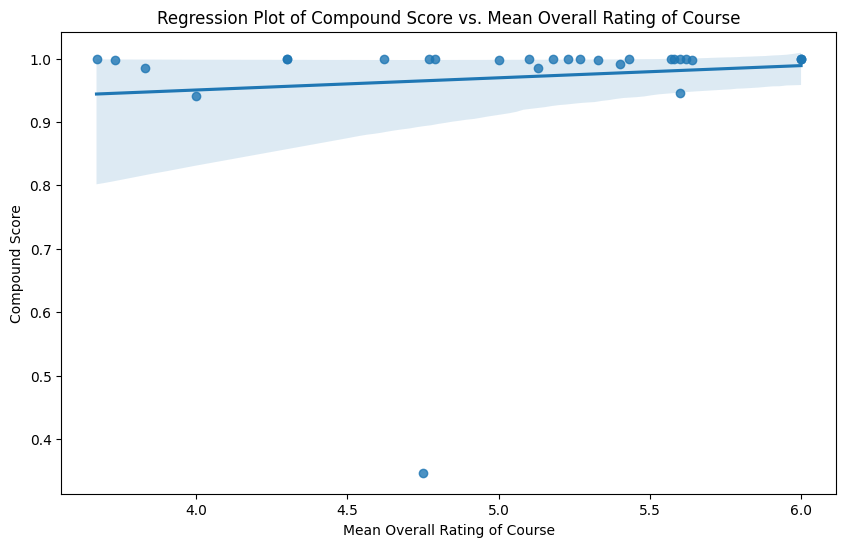

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(data=vaders, x='Mean Overall Rating of Course', y='compound')
plt.title('Regression Plot of Compound Score vs. Mean Overall Rating of Course')
plt.xlabel('Mean Overall Rating of Course')
plt.ylabel('Compound Score')
plt.show()

Notice that the majority of our data point have a compound score very close to 1.0, indicating that at least according to VADER, students are leaving very positive reviews for their instructor. There is a slight upward slope to the regression line, which does suggest some positive correlation, although insignificant. Perhaps a better sentiment analysis method will give us more apparent results?

# ROBERTA PRETRAINED MODEL

The VADER model simply looked at each word in the reviews and scored it individually. However, language depends on context. E.g, someone could say "atrociously amazing," and VADER would score "atrociously" negatively, and "amazing" positively, when actually, the phrase has a positive tone.

Transformer based models can account for this context. We're going to use a model from Hugging Face.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

Now, we're going to use a specific pretrained model that has been pretrained on data for sentiment, provided by Hugging Face. This is essentially transfer learning -- the model has been trained on Twitter comments that were labelled, which we can apply to our own dataset, so we don't need to do any training ourselves!

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Now we have a model and a tokenizer that we can apply to our reviews! Lets test with an example sentence:

In [ ]:
# test run roberta
example = 'Today was an absolutely fantastic day!'
max_length = 512

encoded_text = tokenizer(example, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.0020367 , 0.00637637, 0.9915869 ], dtype=float32)

We can make a dictionary of scores to store our results.

In [ ]:
scores_dict = {
    'roberta_neg' : float(scores[0]),
    'roberta_neu' : float(scores[1]),
    'roberta_pos' : float(scores[2])
}
print(scores_dict)

{'roberta_neg': 0.0020367014221847057, 'roberta_neu': 0.006376372650265694, 'roberta_pos': 0.9915869235992432}


Now we can run it on all the reviews! We can do this by making a function with the same code, which takes in a review, and returns a dictionary. Then we just iterate across all the surveyed courses like before, storing both the vader results and the roberta results. Then, we can just combine the two dictionaries.

In [ ]:
def polarity_scores_roberta(example):
  # tokenize the input text, truncating to the model's maximum sequence length
  encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : float(scores[0]),
    'roberta_neu' : float(scores[1]),
    'roberta_pos' : float(scores[2])
  }
  return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  reviews = row['Reviews']
  course = row['Previous Taught Course']

  # store vader results
  vader_result = sia.polarity_scores(reviews)

  # rename the vader results to be more explicit
  vader_result_rename = {}
  for key, value in vader_result.items():
    vader_result_rename[f"vader_{key}"] = value

  # store roberta results
  roberta_result = polarity_scores_roberta(reviews)

  # combine the two dictionaries
  both = {**vader_result_rename, **roberta_result}
  res[course] = both



  0%|          | 0/28 [00:00<?, ?it/s]

Again, now we have the results, we can store them into a pandas dataframe to merge back onto the main data set.

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Previous Taught Course'})
results_df = results_df.merge(df, how='left')

Let's see:

In [ ]:
results_df

,Previous Taught Course,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Instructor Name,Current Taught Course,Mean Overall Rating of Instruction,Mean Overall Rating of Course,Mean How Much Learned,Mean Effectiveness of Intellectual Challenge,Mean Effectiveness of Stimulating Interest,Mean Average Hours Spent Per Week,Reviews,Prev Was Seminar?
0,HISTORY_103-8_26,0.032,0.715,0.252,0.9996,0.007759,0.034906,0.957335,Paul Gillingham,A Beginner's Guide to Forgery,4.92,4.62,5.00,4.38,5.31,3.769231,Professor Gillingham is amazing. He somehow ma...,True
1,FRENCH_210-0_20,0.065,0.726,0.209,0.9986,0.054528,0.213409,0.732063,Ty Blakeney,A History of Heterosexuality,3.83,3.67,3.50,3.83,3.33,4.916667,an interesting and rewarding course! i came in...,False
2,LEGAL_ST_101-8_1,0.042,0.718,0.240,0.9997,0.287403,0.391654,0.320943,Jesse Yeh,American Outlaw: Writings about Living and Bei...,5.08,4.79,4.71,4.14,5.08,4.428571,This wasn't a hard course but I felt it was po...,True
3,CHEM_105-8_06,0.008,0.811,0.181,0.9979,0.002062,0.017993,0.979945,Kevin Hunter,An analysis of color across science and culture,5.82,5.64,4.36,3.73,5.45,3.000000,I loved this seminar! The teacher is awesome a...,True
4,ENGLISH_105-8_20,0.014,0.721,0.265,0.9993,0.002447,0.012049,0.985504,Meaghan Fritz,Bon Appetit! Mastering the Art of Composition,5.64,5.57,5.21,4.54,5.43,4.357143,TAKE THIS CLASS! BEST CLASS EVER! EASY A! Im s...,True
5,GNDR_ST_101-8_2,0.070,0.755,0.175,0.9973,0.178083,0.267224,0.554693,Amy Partridge,Coalition politics from Chicago and Beyond,3.55,3.73,4.27,4.09,3.36,4.136364,Professor spent most of the time talking. Inte...,True
6,ENGLISH_101-8_20,0.008,0.593,0.399,0.9999,0.002592,0.018408,0.979000,Laura MacKay Hansen,Coming of Age in Literature and Film,5.46,5.62,4.23,4.23,5.54,4.269231,I really enjoyed this course––it wasn't an int...,True
7,ART_HIST_101-6_1,0.021,0.756,0.223,0.9987,0.002234,0.013894,0.983873,Alicia Caticha,Empires of Fashion: from Marie Antoinette to M...,5.36,5.10,5.45,5.09,5.55,4.136364,I loved Professor Alicia Caticha and overall e...,True
8,CLASSICS_101-8_1,0.055,0.670,0.275,0.9994,0.049923,0.198567,0.751510,Germán Campos-Muñoz,Endless Exile: Homelessness in the Ancient Med...,4.70,4.30,4.10,4.40,4.40,5.772727,This course is great if you like learning abou...,True
9,ASTRON_331-0_1,0.042,0.790,0.168,0.9919,0.004233,0.026116,0.969651,Vicky Kalogera,"Exploring AI: Shaping the Future in Science, S...",5.20,5.40,4.60,3.60,5.20,3.500000,Professor Kalogera might actually be my favori...,False


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results_df)

https://docs.google.com/spreadsheets/d/1FBsPvFiWQOw_r3mgP5lhtWEWdvnJP-pspZiQpRSaEvU/edit#gid=0


# Comparing VADER and ROBERTA

Now we can compare the sentiment scores between the two models. We can do this using seaborn's pairplot, which shows comparison between each observation and what each feature looks like.

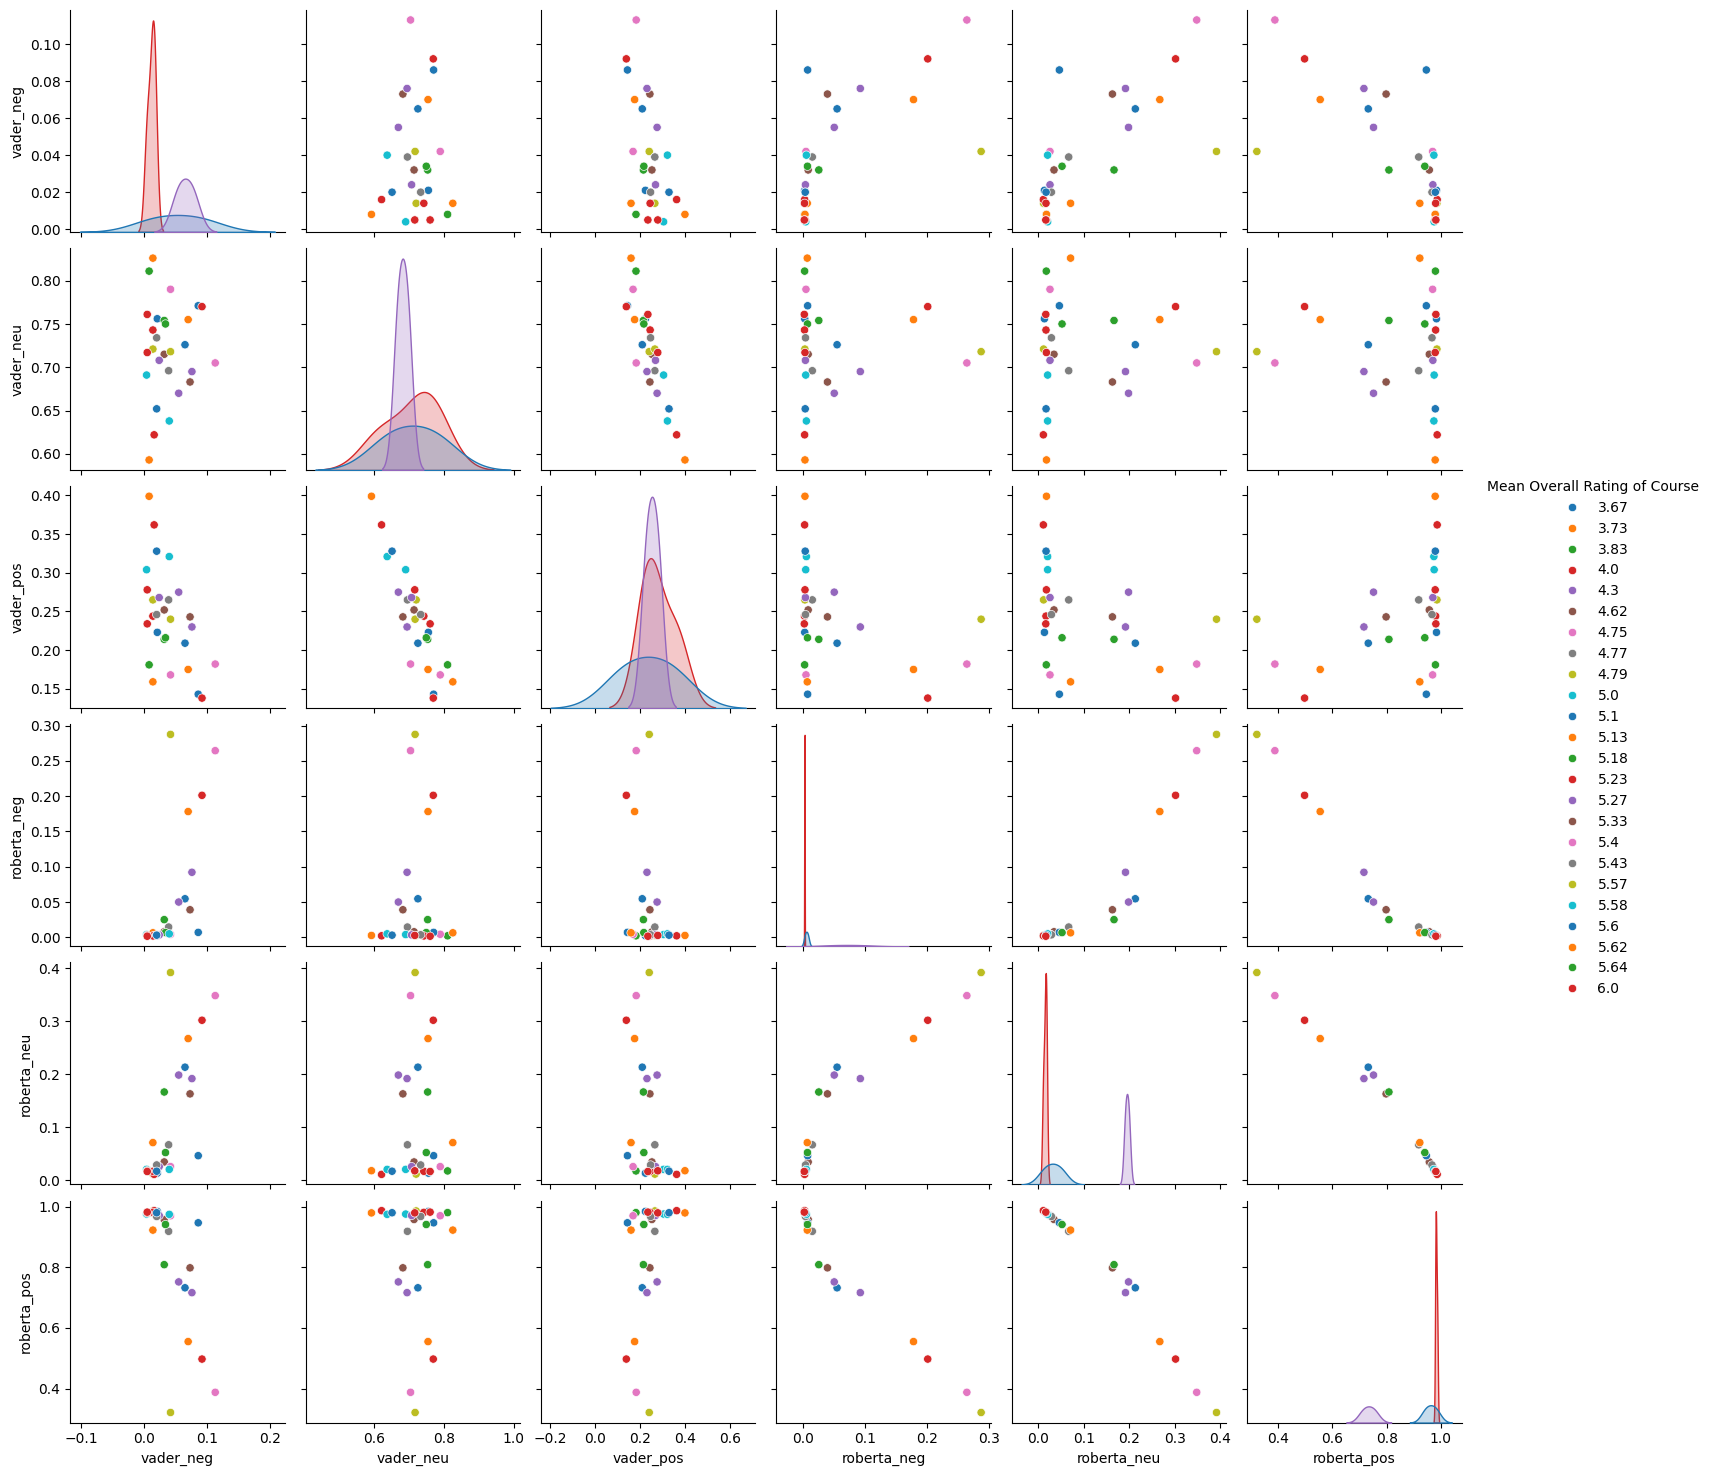

In [ ]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
                                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Mean Overall Rating of Course',
             palette='tab10')
plt.show()

**Score distribution:** VADER utilizes a broader range of values across sentiment categories, while RoBERTa produces more compressed, concentrated distributions.

**Sentiment patterns:** VADER shows multimodal distributions, particularly for positive sentiment. RoBERTa displays sharper, more defined peaks with narrower ranges.

**Correlation with ratings:** Both models show higher positive sentiment scores correlating with higher course ratings (4.75+ appears consistently in high positive regions).

**Model behavior:** VADER demonstrates more sensitivity across the sentiment spectrum, whereas RoBERTa is more conservative, especially when assigning negative sentiment (mostly clustered between 0-0.3).

**Neutral sentiment:** The greatest divergence between models appears in neutral sentiment classification, with VADER showing a much wider distribution than RoBERTa.

**Range differences:** VADER's positive sentiment spans approximately -0.1 to 1.0, while RoBERTa shows more constrained ranges across all sentiment categories.

Anyways, that sums up the methodology behind this website. Leave a like and subscribe!